In [28]:
#Import Libraries, set parametes and create model
import numpy as np
import pybamm
import matplotlib.pyplot as plt
# %matplotlib widget

In [29]:
pybamm.set_logging_level("NOTICE")  # To see updates after each steps of charging and discharging
# solution  = [] # blank array defined for storing solutions after simulation
params = pybamm.ParameterValues("Chen2020")    # calling parameters of chen from pybamm
params.update({"SEI kinetic rate constant [m.s-1]": 1e-15,  # updating rate const from -15to-14 for easy calculation
               "Ambient temperature [K]": 298})
spm = pybamm.lithium_ion.SPM(  # Single Particle Model (SPM) is selected with sub models given below
    {"SEI": "ec reaction limited",  # capacity fade model
        "thermal": "lumped",  # thermal model
        "SEI porosity change": "true",  # porosity change model
        "SEI film resistance": "distributed"}  # film resistance model
)

In [35]:
# Define the constants
n:int = int(input('Enter number of cycles : '))
# n_p=pulse(all cyc), n_c=C_value(each_cyc), rt=rest_time(each_cyc)
# if ">4.2V", cc-cv graph - define 2 functions and call them in if...else as fast() & pulse()
# n_p:int = int(input("Pulse number for all cycle : "))

#From what cycle onwards should updated cycle parameters take effect
# rg:int = int(input("From what cycle : "))

In [36]:
# Define fuction for returning experiment cycle with user parameters
def cycle_with_params(C_value: str, rest_time: str) -> list[str]:

    cycle: list[str] = [
         f"Charge at {C_value} C for 1 minute or until 4.2 V (1 second period)",
         f"Rest for {rest_time} minutes (1 second period)"
         ]

    return cycle

In [37]:
from typing import final

# Define fuction for simulating experiment
def fast(num_cycles: int, solution_list) -> tuple[int, list]:
    '''
    Takes input number of cycles to simulate, and list of previous simulations
    returns number of entries in solution, and list of solutions
    '''
    # n_C: str = input("C value for each cycle : ")
    # rt: str = input("Rest time for each cycle : ")
    n_C: str = "2"
    rt: str = "5"
    cycle1: list[str] = ["Discharge at 5A until 2.5V","Rest for 15 minute"]
    cycle2: list[str] = cycle_with_params(n_C, rt)
    # cycle3: list[str] = ["Charge at 15W until 4.2V", "Hold at 4.2V until 0.01A"]
    solution: list[pybamm.Solution] = solution_list
    num_entries = 0

    exp1 = pybamm.Experiment(operating_conditions=[tuple(cycle1)])
    sim1 = pybamm.Simulation(spm, experiment=exp1, parameter_values=params)
    exp2 = pybamm.Experiment(operating_conditions=[tuple(cycle2)])
    sim2 = pybamm.Simulation(spm, experiment=exp2, parameter_values=params)
    # exp3 = pybamm.Experiment(operating_conditions=[tuple(cycle3)])
    # sim3 = pybamm.Simulation(spm, experiment=exp3, parameter_values=params)

    # When the simulation is run for the first time, the starting_solution is not defined
    if solution == []:
        sol1 = sim1.solve()
        pulse_duration = 360 # Pluse duation is total duration of cycle (1 + 5) minutes
        while(pulse_duration == 360):
            #End time before solving
            initial_time = sol1["Time [s]"].entries[-1]
            sol1 = sim2.solve(starting_solution=sol1)
            #End time after solving
            final_time = sol1["Time [s]"].entries[-1]
            pulse_duration = final_time - initial_time
            # pulse_duration = initial_time
            print(pulse_duration)

        # sol1 = sim3.solve(starting_solution=sol1)
        num_entries: int = len(sol1["Time [s]"].entries)
        # solving and writing results to variable sol1
        solution.append(sol1) # writing sol1 to solution array

    # n = int(input('Enter number of cycles : '))

    for i in range(num_cycles):
        sol2 = sim1.solve(starting_solution=solution[-1])
        pulse_duration = 360 # Pluse duation is total duration of cycle (1 + 5) minutes
        while(pulse_duration == 360):
            #End time before solving
            initial_time = sol2["Time [s]"].entries[-1]
            sol2 = sim2.solve(starting_solution=sol2)
            #End time after solving
            final_time = sol2["Time [s]"].entries[-1]
            pulse_duration = final_time - initial_time
            # pulse_duration = initial_time
            print(pulse_duration)
        # sol2 = sim3.solve(starting_solution=sol2)
        solution.append(sol2)

    return num_entries, solution


In [38]:
#Define plotting function

def plot_given_range(solution, start:int, num_entries:int) -> None:
    '''
    Takes input solution, start and end cycle number, and number of entries to plot
    Plots the voltage and current for the given range of cycles
    '''
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    solutions = solution[start:]

    for sol in solutions:
        t = sol["Time [s]"].entries
        V = sol["Terminal voltage [V]"].entries
        I = sol["Current [A]"].entries
        ax[0].plot(t[:num_entries], V[len(V) - num_entries:])
        ax[1].plot(t[:num_entries], I[len(I) - num_entries:])

    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Voltage [V]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Current [A]")
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()


2023-06-27 07:38:44.300 - [NOTICE] logger.func(15): Cycle 1/1 (110.000 us elapsed) --------------------
2023-06-27 07:38:44.301 - [NOTICE] logger.func(15): Cycle 1/1, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:38:44.356 - [NOTICE] logger.func(15): Cycle 1/1, step 2/2: Rest for 15 minute
2023-06-27 07:38:44.640 - [NOTICE] logger.func(15): Finish experiment simulation, took 339.564 ms
2023-06-27 07:38:44.946 - [NOTICE] logger.func(15): Cycle 2/2 (99.000 us elapsed) --------------------
2023-06-27 07:38:44.948 - [NOTICE] logger.func(15): Cycle 2/2, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:45.017 - [NOTICE] logger.func(15): Cycle 2/2, step 2/2: Rest for 5 minutes
2023-06-27 07:38:45.376 - [NOTICE] logger.func(15): Finish experiment simulation, took 430.485 ms
2023-06-27 07:38:45.386 - [NOTICE] logger.func(15): Cycle 3/3 (213.300 us elapsed) --------------------
2023-06-27 07:38:45.388 - [NOTICE] logger.func(15): Cycle 3/3, step 1/2: Charge at 2 C for 1 m

360.0


2023-06-27 07:38:45.653 - [NOTICE] logger.func(15): Finish experiment simulation, took 267.475 ms
2023-06-27 07:38:45.668 - [NOTICE] logger.func(15): Cycle 4/4 (73.900 us elapsed) --------------------
2023-06-27 07:38:45.668 - [NOTICE] logger.func(15): Cycle 4/4, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:45.674 - [NOTICE] logger.func(15): Cycle 4/4, step 2/2: Rest for 5 minutes
2023-06-27 07:38:45.866 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.773 ms


360.0


2023-06-27 07:38:45.881 - [NOTICE] logger.func(15): Cycle 5/5 (187.100 us elapsed) --------------------
2023-06-27 07:38:45.882 - [NOTICE] logger.func(15): Cycle 5/5, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:45.889 - [NOTICE] logger.func(15): Cycle 5/5, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:46.101 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.602 ms
2023-06-27 07:38:46.123 - [NOTICE] logger.func(15): Cycle 6/6 (160.600 us elapsed) --------------------
2023-06-27 07:38:46.124 - [NOTICE] logger.func(15): Cycle 6/6, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:46.130 - [NOTICE] logger.func(15): Cycle 6/6, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:46.333 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.570 ms
2023-06-27 07:38:46.355 - [NOTICE] logger.func(15): Cycle 7/7 (65.100 us elapsed) --------------------
2023-06-27 07:38:46.355 - [NOTICE] logger.func(15): Cycle 7/7, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:46.362 - [NOTICE] logger.func(15): Cycle 7/7, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:46.630 - [NOTICE] logger.func(15): Finish experiment simulation, took 274.745 ms
2023-06-27 07:38:46.660 - [NOTICE] logger.func(15): Cycle 8/8 (120.900 us elapsed) --------------------
2023-06-27 07:38:46.660 - [NOTICE] logger.func(15): Cycle 8/8, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:46.667 - [NOTICE] logger.func(15): Cycle 8/8, step 2/2: Rest for 5 minutes
2023-06-27 07:38:46.851 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.950 ms


360.0


2023-06-27 07:38:46.890 - [NOTICE] logger.func(15): Cycle 9/9 (98.200 us elapsed) --------------------
2023-06-27 07:38:46.891 - [NOTICE] logger.func(15): Cycle 9/9, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:46.898 - [NOTICE] logger.func(15): Cycle 9/9, step 2/2: Rest for 5 minutes
2023-06-27 07:38:47.088 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.741 ms


360.0


2023-06-27 07:38:47.122 - [NOTICE] logger.func(15): Cycle 10/10 (135.100 us elapsed) --------------------
2023-06-27 07:38:47.123 - [NOTICE] logger.func(15): Cycle 10/10, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:47.128 - [NOTICE] logger.func(15): Cycle 10/10, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:47.335 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.965 ms
2023-06-27 07:38:47.379 - [NOTICE] logger.func(15): Cycle 11/11 (110.200 us elapsed) --------------------
2023-06-27 07:38:47.380 - [NOTICE] logger.func(15): Cycle 11/11, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:47.387 - [NOTICE] logger.func(15): Cycle 11/11, step 2/2: Rest for 5 minutes
2023-06-27 07:38:47.576 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.166 ms


360.0


2023-06-27 07:38:47.630 - [NOTICE] logger.func(15): Cycle 12/12 (141.800 us elapsed) --------------------
2023-06-27 07:38:47.631 - [NOTICE] logger.func(15): Cycle 12/12, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:47.639 - [NOTICE] logger.func(15): Cycle 12/12, step 2/2: Rest for 5 minutes
2023-06-27 07:38:47.830 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.571 ms


360.0


2023-06-27 07:38:47.886 - [NOTICE] logger.func(15): Cycle 13/13 (75.200 us elapsed) --------------------
2023-06-27 07:38:47.887 - [NOTICE] logger.func(15): Cycle 13/13, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:38:47.901 - [NOTICE] logger.func(15): Cycle 13/13, step 2/2: Rest for 15 minute


359.9999999999991


2023-06-27 07:38:48.819 - [NOTICE] logger.func(15): Finish experiment simulation, took 933.253 ms
2023-06-27 07:38:48.872 - [NOTICE] logger.func(15): Cycle 14/14 (110.500 us elapsed) --------------------
2023-06-27 07:38:48.873 - [NOTICE] logger.func(15): Cycle 14/14, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:48.878 - [NOTICE] logger.func(15): Cycle 14/14, step 2/2: Rest for 5 minutes
2023-06-27 07:38:49.069 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.396 ms
2023-06-27 07:38:49.125 - [NOTICE] logger.func(15): Cycle 15/15 (61.400 us elapsed) --------------------
2023-06-27 07:38:49.125 - [NOTICE] logger.func(15): Cycle 15/15, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:49.130 - [NOTICE] logger.func(15): Cycle 15/15, step 2/2: Rest for 5 minutes
2023-06-27 07:38:49.319 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.031 ms


360.0


2023-06-27 07:38:49.384 - [NOTICE] logger.func(15): Cycle 16/16 (66.200 us elapsed) --------------------
2023-06-27 07:38:49.384 - [NOTICE] logger.func(15): Cycle 16/16, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:49.388 - [NOTICE] logger.func(15): Cycle 16/16, step 2/2: Rest for 5 minutes
2023-06-27 07:38:49.577 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.530 ms


360.0


2023-06-27 07:38:49.646 - [NOTICE] logger.func(15): Cycle 17/17 (65.100 us elapsed) --------------------
2023-06-27 07:38:49.646 - [NOTICE] logger.func(15): Cycle 17/17, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:49.650 - [NOTICE] logger.func(15): Cycle 17/17, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:49.867 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.868 ms
2023-06-27 07:38:49.938 - [NOTICE] logger.func(15): Cycle 18/18 (94.600 us elapsed) --------------------
2023-06-27 07:38:49.939 - [NOTICE] logger.func(15): Cycle 18/18, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:49.943 - [NOTICE] logger.func(15): Cycle 18/18, step 2/2: Rest for 5 minutes
2023-06-27 07:38:50.130 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.796 ms


360.0


2023-06-27 07:38:50.196 - [NOTICE] logger.func(15): Cycle 19/19 (62.700 us elapsed) --------------------
2023-06-27 07:38:50.196 - [NOTICE] logger.func(15): Cycle 19/19, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:50.200 - [NOTICE] logger.func(15): Cycle 19/19, step 2/2: Rest for 5 minutes
2023-06-27 07:38:50.399 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.172 ms


360.0


2023-06-27 07:38:50.474 - [NOTICE] logger.func(15): Cycle 20/20 (77.800 us elapsed) --------------------
2023-06-27 07:38:50.475 - [NOTICE] logger.func(15): Cycle 20/20, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:50.483 - [NOTICE] logger.func(15): Cycle 20/20, step 2/2: Rest for 5 minutes
2023-06-27 07:38:50.678 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.288 ms


360.0


2023-06-27 07:38:50.762 - [NOTICE] logger.func(15): Cycle 21/21 (63.000 us elapsed) --------------------
2023-06-27 07:38:50.762 - [NOTICE] logger.func(15): Cycle 21/21, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:50.767 - [NOTICE] logger.func(15): Cycle 21/21, step 2/2: Rest for 5 minutes
2023-06-27 07:38:50.970 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.671 ms


360.0


2023-06-27 07:38:51.064 - [NOTICE] logger.func(15): Cycle 22/22 (80.100 us elapsed) --------------------
2023-06-27 07:38:51.065 - [NOTICE] logger.func(15): Cycle 22/22, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:51.070 - [NOTICE] logger.func(15): Cycle 22/22, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:51.306 - [NOTICE] logger.func(15): Finish experiment simulation, took 241.197 ms
2023-06-27 07:38:51.393 - [NOTICE] logger.func(15): Cycle 23/23 (64.500 us elapsed) --------------------
2023-06-27 07:38:51.394 - [NOTICE] logger.func(15): Cycle 23/23, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:51.399 - [NOTICE] logger.func(15): Cycle 23/23, step 2/2: Rest for 5 minutes
2023-06-27 07:38:51.584 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.580 ms


360.0


2023-06-27 07:38:51.679 - [NOTICE] logger.func(15): Cycle 24/24 (86.000 us elapsed) --------------------
2023-06-27 07:38:51.680 - [NOTICE] logger.func(15): Cycle 24/24, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:51.685 - [NOTICE] logger.func(15): Cycle 24/24, step 2/2: Rest for 5 minutes
2023-06-27 07:38:51.888 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.007 ms


360.0


2023-06-27 07:38:51.991 - [NOTICE] logger.func(15): Cycle 25/25 (103.900 us elapsed) --------------------
2023-06-27 07:38:51.992 - [NOTICE] logger.func(15): Cycle 25/25, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:52.002 - [NOTICE] logger.func(15): Cycle 25/25, step 2/2: Rest for 5 minutes
2023-06-27 07:38:52.212 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.258 ms


360.0


2023-06-27 07:38:52.360 - [NOTICE] logger.func(15): Cycle 26/26 (74.900 us elapsed) --------------------
2023-06-27 07:38:52.361 - [NOTICE] logger.func(15): Cycle 26/26, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:52.364 - [NOTICE] logger.func(15): Cycle 26/26, step 2/2: Rest for 5 minutes
2023-06-27 07:38:52.553 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.689 ms


360.0


2023-06-27 07:38:52.669 - [NOTICE] logger.func(15): Cycle 27/27 (158.000 us elapsed) --------------------
2023-06-27 07:38:52.670 - [NOTICE] logger.func(15): Cycle 27/27, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:52.677 - [NOTICE] logger.func(15): Cycle 27/27, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:52.902 - [NOTICE] logger.func(15): Finish experiment simulation, took 232.816 ms
2023-06-27 07:38:53.015 - [NOTICE] logger.func(15): Cycle 28/28 (64.800 us elapsed) --------------------
2023-06-27 07:38:53.015 - [NOTICE] logger.func(15): Cycle 28/28, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:53.020 - [NOTICE] logger.func(15): Cycle 28/28, step 2/2: Rest for 5 minutes
2023-06-27 07:38:53.207 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.287 ms


360.0


2023-06-27 07:38:53.356 - [NOTICE] logger.func(15): Cycle 29/29 (67.500 us elapsed) --------------------
2023-06-27 07:38:53.357 - [NOTICE] logger.func(15): Cycle 29/29, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:53.364 - [NOTICE] logger.func(15): Cycle 29/29, step 2/2: Rest for 5 minutes
2023-06-27 07:38:53.557 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.055 ms


360.0


2023-06-27 07:38:53.676 - [NOTICE] logger.func(15): Cycle 30/30 (138.500 us elapsed) --------------------
2023-06-27 07:38:53.677 - [NOTICE] logger.func(15): Cycle 30/30, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:38:53.688 - [NOTICE] logger.func(15): Cycle 30/30, step 2/2: Rest for 15 minute
2023-06-27 07:38:53.881 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.732 ms


359.9999999999982


2023-06-27 07:38:54.030 - [NOTICE] logger.func(15): Cycle 31/31 (84.200 us elapsed) --------------------
2023-06-27 07:38:54.032 - [NOTICE] logger.func(15): Cycle 31/31, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:54.041 - [NOTICE] logger.func(15): Cycle 31/31, step 2/2: Rest for 5 minutes
2023-06-27 07:38:54.240 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.068 ms
2023-06-27 07:38:54.358 - [NOTICE] logger.func(15): Cycle 32/32 (65.300 us elapsed) --------------------
2023-06-27 07:38:54.359 - [NOTICE] logger.func(15): Cycle 32/32, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:54.362 - [NOTICE] logger.func(15): Cycle 32/32, step 2/2: Rest for 5 minutes
2023-06-27 07:38:54.558 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.960 ms


360.0


2023-06-27 07:38:54.712 - [NOTICE] logger.func(15): Cycle 33/33 (273.700 us elapsed) --------------------
2023-06-27 07:38:54.713 - [NOTICE] logger.func(15): Cycle 33/33, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:54.723 - [NOTICE] logger.func(15): Cycle 33/33, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:55.276 - [NOTICE] logger.func(15): Finish experiment simulation, took 563.907 ms
2023-06-27 07:38:55.407 - [NOTICE] logger.func(15): Cycle 34/34 (65.500 us elapsed) --------------------
2023-06-27 07:38:55.408 - [NOTICE] logger.func(15): Cycle 34/34, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:55.413 - [NOTICE] logger.func(15): Cycle 34/34, step 2/2: Rest for 5 minutes
2023-06-27 07:38:55.601 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.283 ms


360.0


2023-06-27 07:38:55.746 - [NOTICE] logger.func(15): Cycle 35/35 (74.000 us elapsed) --------------------
2023-06-27 07:38:55.746 - [NOTICE] logger.func(15): Cycle 35/35, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:55.750 - [NOTICE] logger.func(15): Cycle 35/35, step 2/2: Rest for 5 minutes
2023-06-27 07:38:55.949 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.543 ms


360.0


2023-06-27 07:38:56.094 - [NOTICE] logger.func(15): Cycle 36/36 (68.600 us elapsed) --------------------
2023-06-27 07:38:56.094 - [NOTICE] logger.func(15): Cycle 36/36, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:56.100 - [NOTICE] logger.func(15): Cycle 36/36, step 2/2: Rest for 5 minutes
2023-06-27 07:38:56.299 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.659 ms


360.0


2023-06-27 07:38:56.485 - [NOTICE] logger.func(15): Cycle 37/37 (70.200 us elapsed) --------------------
2023-06-27 07:38:56.485 - [NOTICE] logger.func(15): Cycle 37/37, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:56.490 - [NOTICE] logger.func(15): Cycle 37/37, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:56.711 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.637 ms
2023-06-27 07:38:56.862 - [NOTICE] logger.func(15): Cycle 38/38 (91.500 us elapsed) --------------------
2023-06-27 07:38:56.862 - [NOTICE] logger.func(15): Cycle 38/38, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:56.866 - [NOTICE] logger.func(15): Cycle 38/38, step 2/2: Rest for 5 minutes
2023-06-27 07:38:57.084 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.036 ms


360.0


2023-06-27 07:38:57.241 - [NOTICE] logger.func(15): Cycle 39/39 (69.300 us elapsed) --------------------
2023-06-27 07:38:57.242 - [NOTICE] logger.func(15): Cycle 39/39, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:57.249 - [NOTICE] logger.func(15): Cycle 39/39, step 2/2: Rest for 5 minutes
2023-06-27 07:38:57.463 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.494 ms


360.0


2023-06-27 07:38:57.666 - [NOTICE] logger.func(15): Cycle 40/40 (64.400 us elapsed) --------------------
2023-06-27 07:38:57.667 - [NOTICE] logger.func(15): Cycle 40/40, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:57.670 - [NOTICE] logger.func(15): Cycle 40/40, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:57.904 - [NOTICE] logger.func(15): Finish experiment simulation, took 236.642 ms
2023-06-27 07:38:58.092 - [NOTICE] logger.func(15): Cycle 41/41 (68.300 us elapsed) --------------------
2023-06-27 07:38:58.093 - [NOTICE] logger.func(15): Cycle 41/41, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:58.098 - [NOTICE] logger.func(15): Cycle 41/41, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:38:58.321 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.176 ms
2023-06-27 07:38:58.487 - [NOTICE] logger.func(15): Cycle 42/42 (155.400 us elapsed) --------------------
2023-06-27 07:38:58.488 - [NOTICE] logger.func(15): Cycle 42/42, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:58.496 - [NOTICE] logger.func(15): Cycle 42/42, step 2/2: Rest for 5 minutes
2023-06-27 07:38:58.704 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.376 ms


360.0


2023-06-27 07:38:58.890 - [NOTICE] logger.func(15): Cycle 43/43 (70.600 us elapsed) --------------------
2023-06-27 07:38:58.890 - [NOTICE] logger.func(15): Cycle 43/43, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:58.894 - [NOTICE] logger.func(15): Cycle 43/43, step 2/2: Rest for 5 minutes
2023-06-27 07:38:59.093 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.130 ms


360.0


2023-06-27 07:38:59.286 - [NOTICE] logger.func(15): Cycle 44/44 (72.000 us elapsed) --------------------
2023-06-27 07:38:59.287 - [NOTICE] logger.func(15): Cycle 44/44, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:59.292 - [NOTICE] logger.func(15): Cycle 44/44, step 2/2: Rest for 5 minutes
2023-06-27 07:38:59.486 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.802 ms


360.0


2023-06-27 07:38:59.666 - [NOTICE] logger.func(15): Cycle 45/45 (105.100 us elapsed) --------------------
2023-06-27 07:38:59.667 - [NOTICE] logger.func(15): Cycle 45/45, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:38:59.672 - [NOTICE] logger.func(15): Cycle 45/45, step 2/2: Rest for 5 minutes
2023-06-27 07:38:59.873 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.071 ms


360.0


2023-06-27 07:39:00.060 - [NOTICE] logger.func(15): Cycle 46/46 (111.700 us elapsed) --------------------
2023-06-27 07:39:00.061 - [NOTICE] logger.func(15): Cycle 46/46, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:00.065 - [NOTICE] logger.func(15): Cycle 46/46, step 2/2: Rest for 5 minutes
2023-06-27 07:39:00.261 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.780 ms


360.0


2023-06-27 07:39:00.498 - [NOTICE] logger.func(15): Cycle 47/47 (74.000 us elapsed) --------------------
2023-06-27 07:39:00.499 - [NOTICE] logger.func(15): Cycle 47/47, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:00.504 - [NOTICE] logger.func(15): Cycle 47/47, step 2/2: Rest for 5 minutes
2023-06-27 07:39:00.708 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.362 ms


360.0


2023-06-27 07:39:00.901 - [NOTICE] logger.func(15): Cycle 48/48 (66.400 us elapsed) --------------------
2023-06-27 07:39:00.902 - [NOTICE] logger.func(15): Cycle 48/48, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:00.908 - [NOTICE] logger.func(15): Cycle 48/48, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:01.099 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.537 ms
2023-06-27 07:39:01.289 - [NOTICE] logger.func(15): Cycle 49/49 (65.800 us elapsed) --------------------
2023-06-27 07:39:01.289 - [NOTICE] logger.func(15): Cycle 49/49, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:01.293 - [NOTICE] logger.func(15): Cycle 49/49, step 2/2: Rest for 5 minutes
2023-06-27 07:39:01.479 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.626 ms


360.0


2023-06-27 07:39:01.672 - [NOTICE] logger.func(15): Cycle 50/50 (66.700 us elapsed) --------------------
2023-06-27 07:39:01.673 - [NOTICE] logger.func(15): Cycle 50/50, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:01.678 - [NOTICE] logger.func(15): Cycle 50/50, step 2/2: Rest for 5 minutes
2023-06-27 07:39:01.871 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.912 ms


360.0


2023-06-27 07:39:02.072 - [NOTICE] logger.func(15): Cycle 51/51 (92.700 us elapsed) --------------------
2023-06-27 07:39:02.072 - [NOTICE] logger.func(15): Cycle 51/51, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:02.077 - [NOTICE] logger.func(15): Cycle 51/51, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:02.275 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.063 ms
2023-06-27 07:39:02.480 - [NOTICE] logger.func(15): Cycle 52/52 (105.700 us elapsed) --------------------
2023-06-27 07:39:02.482 - [NOTICE] logger.func(15): Cycle 52/52, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:02.489 - [NOTICE] logger.func(15): Cycle 52/52, step 2/2: Rest for 5 minutes
2023-06-27 07:39:02.678 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.281 ms


360.0


2023-06-27 07:39:02.886 - [NOTICE] logger.func(15): Cycle 53/53 (68.300 us elapsed) --------------------
2023-06-27 07:39:02.887 - [NOTICE] logger.func(15): Cycle 53/53, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:39:02.898 - [NOTICE] logger.func(15): Cycle 53/53, step 2/2: Rest for 15 minute
2023-06-27 07:39:03.086 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.152 ms


342.7836676472143


2023-06-27 07:39:03.292 - [NOTICE] logger.func(15): Cycle 54/54 (77.000 us elapsed) --------------------
2023-06-27 07:39:03.293 - [NOTICE] logger.func(15): Cycle 54/54, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:03.297 - [NOTICE] logger.func(15): Cycle 54/54, step 2/2: Rest for 5 minutes
2023-06-27 07:39:03.530 - [NOTICE] logger.func(15): Finish experiment simulation, took 236.721 ms
2023-06-27 07:39:03.735 - [NOTICE] logger.func(15): Cycle 55/55 (160.900 us elapsed) --------------------
2023-06-27 07:39:03.736 - [NOTICE] logger.func(15): Cycle 55/55, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:03.741 - [NOTICE] logger.func(15): Cycle 55/55, step 2/2: Rest for 5 minutes
2023-06-27 07:39:03.932 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.811 ms


360.0


2023-06-27 07:39:04.147 - [NOTICE] logger.func(15): Cycle 56/56 (70.300 us elapsed) --------------------
2023-06-27 07:39:04.147 - [NOTICE] logger.func(15): Cycle 56/56, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:04.151 - [NOTICE] logger.func(15): Cycle 56/56, step 2/2: Rest for 5 minutes
2023-06-27 07:39:04.359 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.594 ms


360.0


2023-06-27 07:39:04.586 - [NOTICE] logger.func(15): Cycle 57/57 (62.300 us elapsed) --------------------
2023-06-27 07:39:04.587 - [NOTICE] logger.func(15): Cycle 57/57, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:04.593 - [NOTICE] logger.func(15): Cycle 57/57, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:05.154 - [NOTICE] logger.func(15): Finish experiment simulation, took 567.370 ms
2023-06-27 07:39:05.368 - [NOTICE] logger.func(15): Cycle 58/58 (100.600 us elapsed) --------------------
2023-06-27 07:39:05.368 - [NOTICE] logger.func(15): Cycle 58/58, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:05.374 - [NOTICE] logger.func(15): Cycle 58/58, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:05.569 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.758 ms
2023-06-27 07:39:05.795 - [NOTICE] logger.func(15): Cycle 59/59 (103.700 us elapsed) --------------------
2023-06-27 07:39:05.796 - [NOTICE] logger.func(15): Cycle 59/59, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:05.801 - [NOTICE] logger.func(15): Cycle 59/59, step 2/2: Rest for 5 minutes
2023-06-27 07:39:05.996 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.586 ms


360.0


2023-06-27 07:39:06.228 - [NOTICE] logger.func(15): Cycle 60/60 (67.700 us elapsed) --------------------
2023-06-27 07:39:06.229 - [NOTICE] logger.func(15): Cycle 60/60, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:39:06.238 - [NOTICE] logger.func(15): Cycle 60/60, step 2/2: Rest for 15 minute


360.00000000000364


2023-06-27 07:39:06.446 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.965 ms
2023-06-27 07:39:06.686 - [NOTICE] logger.func(15): Cycle 61/61 (79.400 us elapsed) --------------------
2023-06-27 07:39:06.687 - [NOTICE] logger.func(15): Cycle 61/61, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:06.693 - [NOTICE] logger.func(15): Cycle 61/61, step 2/2: Rest for 5 minutes
2023-06-27 07:39:06.881 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.712 ms
2023-06-27 07:39:07.122 - [NOTICE] logger.func(15): Cycle 62/62 (149.700 us elapsed) --------------------
2023-06-27 07:39:07.123 - [NOTICE] logger.func(15): Cycle 62/62, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:07.127 - [NOTICE] logger.func(15): Cycle 62/62, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:07.326 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.655 ms
2023-06-27 07:39:07.573 - [NOTICE] logger.func(15): Cycle 63/63 (69.800 us elapsed) --------------------
2023-06-27 07:39:07.573 - [NOTICE] logger.func(15): Cycle 63/63, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:07.578 - [NOTICE] logger.func(15): Cycle 63/63, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:07.770 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.284 ms
2023-06-27 07:39:08.059 - [NOTICE] logger.func(15): Cycle 64/64 (126.500 us elapsed) --------------------
2023-06-27 07:39:08.060 - [NOTICE] logger.func(15): Cycle 64/64, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:08.063 - [NOTICE] logger.func(15): Cycle 64/64, step 2/2: Rest for 5 minutes
2023-06-27 07:39:08.247 - [NOTICE] logger.func(15): Finish experiment simulation, took 187.745 ms


360.0


2023-06-27 07:39:08.510 - [NOTICE] logger.func(15): Cycle 65/65 (84.300 us elapsed) --------------------
2023-06-27 07:39:08.511 - [NOTICE] logger.func(15): Cycle 65/65, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:08.516 - [NOTICE] logger.func(15): Cycle 65/65, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:08.718 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.186 ms
2023-06-27 07:39:08.970 - [NOTICE] logger.func(15): Cycle 66/66 (77.600 us elapsed) --------------------
2023-06-27 07:39:08.970 - [NOTICE] logger.func(15): Cycle 66/66, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:08.975 - [NOTICE] logger.func(15): Cycle 66/66, step 2/2: Rest for 5 minutes
2023-06-27 07:39:09.170 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.387 ms


360.0


2023-06-27 07:39:09.428 - [NOTICE] logger.func(15): Cycle 67/67 (69.100 us elapsed) --------------------
2023-06-27 07:39:09.428 - [NOTICE] logger.func(15): Cycle 67/67, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:09.433 - [NOTICE] logger.func(15): Cycle 67/67, step 2/2: Rest for 5 minutes
2023-06-27 07:39:09.635 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.315 ms


360.0


2023-06-27 07:39:09.901 - [NOTICE] logger.func(15): Cycle 68/68 (66.000 us elapsed) --------------------
2023-06-27 07:39:09.901 - [NOTICE] logger.func(15): Cycle 68/68, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:09.906 - [NOTICE] logger.func(15): Cycle 68/68, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:10.102 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.382 ms
2023-06-27 07:39:10.364 - [NOTICE] logger.func(15): Cycle 69/69 (83.300 us elapsed) --------------------
2023-06-27 07:39:10.364 - [NOTICE] logger.func(15): Cycle 69/69, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:10.368 - [NOTICE] logger.func(15): Cycle 69/69, step 2/2: Rest for 5 minutes
2023-06-27 07:39:10.554 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.152 ms


360.0


2023-06-27 07:39:10.865 - [NOTICE] logger.func(15): Cycle 70/70 (69.100 us elapsed) --------------------
2023-06-27 07:39:10.866 - [NOTICE] logger.func(15): Cycle 70/70, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:10.871 - [NOTICE] logger.func(15): Cycle 70/70, step 2/2: Rest for 5 minutes
2023-06-27 07:39:11.070 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.765 ms


360.0


2023-06-27 07:39:11.346 - [NOTICE] logger.func(15): Cycle 71/71 (138.700 us elapsed) --------------------
2023-06-27 07:39:11.347 - [NOTICE] logger.func(15): Cycle 71/71, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:11.351 - [NOTICE] logger.func(15): Cycle 71/71, step 2/2: Rest for 5 minutes
2023-06-27 07:39:11.550 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.139 ms


360.0


2023-06-27 07:39:11.894 - [NOTICE] logger.func(15): Cycle 72/72 (84.000 us elapsed) --------------------
2023-06-27 07:39:11.895 - [NOTICE] logger.func(15): Cycle 72/72, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:11.899 - [NOTICE] logger.func(15): Cycle 72/72, step 2/2: Rest for 5 minutes
2023-06-27 07:39:12.096 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.974 ms


360.0


2023-06-27 07:39:12.383 - [NOTICE] logger.func(15): Cycle 73/73 (110.000 us elapsed) --------------------
2023-06-27 07:39:12.383 - [NOTICE] logger.func(15): Cycle 73/73, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:12.389 - [NOTICE] logger.func(15): Cycle 73/73, step 2/2: Rest for 5 minutes
2023-06-27 07:39:12.590 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.417 ms


360.0


2023-06-27 07:39:12.886 - [NOTICE] logger.func(15): Cycle 74/74 (112.000 us elapsed) --------------------
2023-06-27 07:39:12.887 - [NOTICE] logger.func(15): Cycle 74/74, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:12.891 - [NOTICE] logger.func(15): Cycle 74/74, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:13.080 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.523 ms
2023-06-27 07:39:13.382 - [NOTICE] logger.func(15): Cycle 75/75 (72.900 us elapsed) --------------------
2023-06-27 07:39:13.383 - [NOTICE] logger.func(15): Cycle 75/75, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:13.388 - [NOTICE] logger.func(15): Cycle 75/75, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:13.578 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.549 ms
2023-06-27 07:39:13.872 - [NOTICE] logger.func(15): Cycle 76/76 (73.200 us elapsed) --------------------
2023-06-27 07:39:13.873 - [NOTICE] logger.func(15): Cycle 76/76, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:13.877 - [NOTICE] logger.func(15): Cycle 76/76, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:14.069 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.288 ms
2023-06-27 07:39:14.365 - [NOTICE] logger.func(15): Cycle 77/77 (76.400 us elapsed) --------------------
2023-06-27 07:39:14.366 - [NOTICE] logger.func(15): Cycle 77/77, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:14.370 - [NOTICE] logger.func(15): Cycle 77/77, step 2/2: Rest for 5 minutes
2023-06-27 07:39:14.555 - [NOTICE] logger.func(15): Finish experiment simulation, took 188.847 ms


360.0


2023-06-27 07:39:14.858 - [NOTICE] logger.func(15): Cycle 78/78 (68.600 us elapsed) --------------------
2023-06-27 07:39:14.859 - [NOTICE] logger.func(15): Cycle 78/78, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:14.864 - [NOTICE] logger.func(15): Cycle 78/78, step 2/2: Rest for 5 minutes
2023-06-27 07:39:15.062 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.935 ms


360.0


2023-06-27 07:39:15.371 - [NOTICE] logger.func(15): Cycle 79/79 (83.900 us elapsed) --------------------
2023-06-27 07:39:15.372 - [NOTICE] logger.func(15): Cycle 79/79, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:15.376 - [NOTICE] logger.func(15): Cycle 79/79, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:15.611 - [NOTICE] logger.func(15): Finish experiment simulation, took 238.346 ms
2023-06-27 07:39:15.923 - [NOTICE] logger.func(15): Cycle 80/80 (70.500 us elapsed) --------------------
2023-06-27 07:39:15.924 - [NOTICE] logger.func(15): Cycle 80/80, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:15.929 - [NOTICE] logger.func(15): Cycle 80/80, step 2/2: Rest for 5 minutes
2023-06-27 07:39:16.122 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.784 ms


360.0


2023-06-27 07:39:16.449 - [NOTICE] logger.func(15): Cycle 81/81 (68.900 us elapsed) --------------------
2023-06-27 07:39:16.450 - [NOTICE] logger.func(15): Cycle 81/81, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:16.455 - [NOTICE] logger.func(15): Cycle 81/81, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:16.655 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.068 ms
2023-06-27 07:39:16.973 - [NOTICE] logger.func(15): Cycle 82/82 (114.400 us elapsed) --------------------
2023-06-27 07:39:16.974 - [NOTICE] logger.func(15): Cycle 82/82, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:16.981 - [NOTICE] logger.func(15): Cycle 82/82, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:17.175 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.752 ms
2023-06-27 07:39:17.497 - [NOTICE] logger.func(15): Cycle 83/83 (67.300 us elapsed) --------------------
2023-06-27 07:39:17.498 - [NOTICE] logger.func(15): Cycle 83/83, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:39:17.509 - [NOTICE] logger.func(15): Cycle 83/83, step 2/2: Rest for 15 minute
2023-06-27 07:39:17.698 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.615 ms


342.4621884160879


2023-06-27 07:39:18.019 - [NOTICE] logger.func(15): Cycle 84/84 (82.800 us elapsed) --------------------
2023-06-27 07:39:18.019 - [NOTICE] logger.func(15): Cycle 84/84, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:18.024 - [NOTICE] logger.func(15): Cycle 84/84, step 2/2: Rest for 5 minutes
2023-06-27 07:39:18.218 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.448 ms
2023-06-27 07:39:18.538 - [NOTICE] logger.func(15): Cycle 85/85 (71.200 us elapsed) --------------------
2023-06-27 07:39:18.538 - [NOTICE] logger.func(15): Cycle 85/85, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:18.543 - [NOTICE] logger.func(15): Cycle 85/85, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:19.147 - [NOTICE] logger.func(15): Finish experiment simulation, took 607.922 ms
2023-06-27 07:39:19.476 - [NOTICE] logger.func(15): Cycle 86/86 (72.200 us elapsed) --------------------
2023-06-27 07:39:19.477 - [NOTICE] logger.func(15): Cycle 86/86, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:19.482 - [NOTICE] logger.func(15): Cycle 86/86, step 2/2: Rest for 5 minutes
2023-06-27 07:39:19.673 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.609 ms


360.0


2023-06-27 07:39:20.001 - [NOTICE] logger.func(15): Cycle 87/87 (72.400 us elapsed) --------------------
2023-06-27 07:39:20.002 - [NOTICE] logger.func(15): Cycle 87/87, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:20.008 - [NOTICE] logger.func(15): Cycle 87/87, step 2/2: Rest for 5 minutes
2023-06-27 07:39:20.199 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.347 ms


360.0


2023-06-27 07:39:20.591 - [NOTICE] logger.func(15): Cycle 88/88 (70.300 us elapsed) --------------------
2023-06-27 07:39:20.592 - [NOTICE] logger.func(15): Cycle 88/88, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:20.597 - [NOTICE] logger.func(15): Cycle 88/88, step 2/2: Rest for 5 minutes
2023-06-27 07:39:20.804 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.369 ms


360.0


2023-06-27 07:39:21.145 - [NOTICE] logger.func(15): Cycle 89/89 (100.600 us elapsed) --------------------
2023-06-27 07:39:21.146 - [NOTICE] logger.func(15): Cycle 89/89, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:21.151 - [NOTICE] logger.func(15): Cycle 89/89, step 2/2: Rest for 5 minutes
2023-06-27 07:39:21.346 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.697 ms


360.0


2023-06-27 07:39:21.690 - [NOTICE] logger.func(15): Cycle 90/90 (164.200 us elapsed) --------------------
2023-06-27 07:39:21.691 - [NOTICE] logger.func(15): Cycle 90/90, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:21.696 - [NOTICE] logger.func(15): Cycle 90/90, step 2/2: Rest for 5 minutes
2023-06-27 07:39:21.885 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.715 ms


360.0


2023-06-27 07:39:22.235 - [NOTICE] logger.func(15): Cycle 91/91 (70.000 us elapsed) --------------------
2023-06-27 07:39:22.236 - [NOTICE] logger.func(15): Cycle 91/91, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:22.241 - [NOTICE] logger.func(15): Cycle 91/91, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:22.436 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.083 ms
2023-06-27 07:39:22.792 - [NOTICE] logger.func(15): Cycle 92/92 (80.900 us elapsed) --------------------
2023-06-27 07:39:22.793 - [NOTICE] logger.func(15): Cycle 92/92, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:22.798 - [NOTICE] logger.func(15): Cycle 92/92, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:22.993 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.721 ms
2023-06-27 07:39:23.351 - [NOTICE] logger.func(15): Cycle 93/93 (72.700 us elapsed) --------------------
2023-06-27 07:39:23.352 - [NOTICE] logger.func(15): Cycle 93/93, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:23.358 - [NOTICE] logger.func(15): Cycle 93/93, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:23.555 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.777 ms
2023-06-27 07:39:23.923 - [NOTICE] logger.func(15): Cycle 94/94 (165.300 us elapsed) --------------------
2023-06-27 07:39:23.924 - [NOTICE] logger.func(15): Cycle 94/94, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:23.929 - [NOTICE] logger.func(15): Cycle 94/94, step 2/2: Rest for 5 minutes
2023-06-27 07:39:24.121 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.954 ms


360.0


2023-06-27 07:39:24.501 - [NOTICE] logger.func(15): Cycle 95/95 (70.700 us elapsed) --------------------
2023-06-27 07:39:24.502 - [NOTICE] logger.func(15): Cycle 95/95, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:24.506 - [NOTICE] logger.func(15): Cycle 95/95, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:24.740 - [NOTICE] logger.func(15): Finish experiment simulation, took 238.240 ms
2023-06-27 07:39:25.120 - [NOTICE] logger.func(15): Cycle 96/96 (78.100 us elapsed) --------------------
2023-06-27 07:39:25.121 - [NOTICE] logger.func(15): Cycle 96/96, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:25.126 - [NOTICE] logger.func(15): Cycle 96/96, step 2/2: Rest for 5 minutes
2023-06-27 07:39:25.313 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.304 ms


360.0


2023-06-27 07:39:25.684 - [NOTICE] logger.func(15): Cycle 97/97 (69.000 us elapsed) --------------------
2023-06-27 07:39:25.684 - [NOTICE] logger.func(15): Cycle 97/97, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:25.689 - [NOTICE] logger.func(15): Cycle 97/97, step 2/2: Rest for 5 minutes
2023-06-27 07:39:25.884 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.620 ms


360.0


2023-06-27 07:39:26.265 - [NOTICE] logger.func(15): Cycle 98/98 (117.100 us elapsed) --------------------
2023-06-27 07:39:26.266 - [NOTICE] logger.func(15): Cycle 98/98, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:26.271 - [NOTICE] logger.func(15): Cycle 98/98, step 2/2: Rest for 5 minutes
2023-06-27 07:39:26.467 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.005 ms


360.0


2023-06-27 07:39:26.853 - [NOTICE] logger.func(15): Cycle 99/99 (75.400 us elapsed) --------------------
2023-06-27 07:39:26.853 - [NOTICE] logger.func(15): Cycle 99/99, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:26.859 - [NOTICE] logger.func(15): Cycle 99/99, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:27.062 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.443 ms
2023-06-27 07:39:27.455 - [NOTICE] logger.func(15): Cycle 100/100 (99.200 us elapsed) --------------------
2023-06-27 07:39:27.455 - [NOTICE] logger.func(15): Cycle 100/100, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:27.460 - [NOTICE] logger.func(15): Cycle 100/100, step 2/2: Rest for 5 minutes
2023-06-27 07:39:27.664 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.183 ms


360.0


2023-06-27 07:39:28.069 - [NOTICE] logger.func(15): Cycle 101/101 (76.800 us elapsed) --------------------
2023-06-27 07:39:28.070 - [NOTICE] logger.func(15): Cycle 101/101, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:28.075 - [NOTICE] logger.func(15): Cycle 101/101, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:28.275 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.442 ms
2023-06-27 07:39:28.726 - [NOTICE] logger.func(15): Cycle 102/102 (157.200 us elapsed) --------------------
2023-06-27 07:39:28.727 - [NOTICE] logger.func(15): Cycle 102/102, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:28.732 - [NOTICE] logger.func(15): Cycle 102/102, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:28.933 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.268 ms
2023-06-27 07:39:29.340 - [NOTICE] logger.func(15): Cycle 103/103 (69.700 us elapsed) --------------------
2023-06-27 07:39:29.341 - [NOTICE] logger.func(15): Cycle 103/103, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:29.345 - [NOTICE] logger.func(15): Cycle 103/103, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:29.537 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.138 ms
2023-06-27 07:39:29.936 - [NOTICE] logger.func(15): Cycle 104/104 (71.000 us elapsed) --------------------
2023-06-27 07:39:29.936 - [NOTICE] logger.func(15): Cycle 104/104, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:29.941 - [NOTICE] logger.func(15): Cycle 104/104, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:30.141 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.329 ms
2023-06-27 07:39:30.550 - [NOTICE] logger.func(15): Cycle 105/105 (168.400 us elapsed) --------------------
2023-06-27 07:39:30.551 - [NOTICE] logger.func(15): Cycle 105/105, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:30.558 - [NOTICE] logger.func(15): Cycle 105/105, step 2/2: Rest for 5 minutes
2023-06-27 07:39:30.752 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.374 ms


360.0


2023-06-27 07:39:31.164 - [NOTICE] logger.func(15): Cycle 106/106 (67.300 us elapsed) --------------------
2023-06-27 07:39:31.165 - [NOTICE] logger.func(15): Cycle 106/106, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:39:31.176 - [NOTICE] logger.func(15): Cycle 106/106, step 2/2: Rest for 15 minute


342.04505923794204


2023-06-27 07:39:31.396 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.882 ms
2023-06-27 07:39:31.812 - [NOTICE] logger.func(15): Cycle 107/107 (74.200 us elapsed) --------------------
2023-06-27 07:39:31.813 - [NOTICE] logger.func(15): Cycle 107/107, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:31.818 - [NOTICE] logger.func(15): Cycle 107/107, step 2/2: Rest for 5 minutes
2023-06-27 07:39:32.027 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.322 ms
2023-06-27 07:39:32.450 - [NOTICE] logger.func(15): Cycle 108/108 (72.100 us elapsed) --------------------
2023-06-27 07:39:32.451 - [NOTICE] logger.func(15): Cycle 108/108, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:32.455 - [NOTICE] logger.func(15): Cycle 108/108, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:32.665 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.936 ms
2023-06-27 07:39:33.085 - [NOTICE] logger.func(15): Cycle 109/109 (76.200 us elapsed) --------------------
2023-06-27 07:39:33.086 - [NOTICE] logger.func(15): Cycle 109/109, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:33.091 - [NOTICE] logger.func(15): Cycle 109/109, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:33.281 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.536 ms
2023-06-27 07:39:33.706 - [NOTICE] logger.func(15): Cycle 110/110 (71.200 us elapsed) --------------------
2023-06-27 07:39:33.707 - [NOTICE] logger.func(15): Cycle 110/110, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:33.712 - [NOTICE] logger.func(15): Cycle 110/110, step 2/2: Rest for 5 minutes
2023-06-27 07:39:33.901 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.773 ms


360.0


2023-06-27 07:39:34.367 - [NOTICE] logger.func(15): Cycle 111/111 (115.600 us elapsed) --------------------
2023-06-27 07:39:34.368 - [NOTICE] logger.func(15): Cycle 111/111, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:34.373 - [NOTICE] logger.func(15): Cycle 111/111, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:34.564 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.963 ms
2023-06-27 07:39:35.009 - [NOTICE] logger.func(15): Cycle 112/112 (81.600 us elapsed) --------------------
2023-06-27 07:39:35.010 - [NOTICE] logger.func(15): Cycle 112/112, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:35.015 - [NOTICE] logger.func(15): Cycle 112/112, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:35.219 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.362 ms
2023-06-27 07:39:35.664 - [NOTICE] logger.func(15): Cycle 113/113 (72.900 us elapsed) --------------------
2023-06-27 07:39:35.664 - [NOTICE] logger.func(15): Cycle 113/113, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:35.669 - [NOTICE] logger.func(15): Cycle 113/113, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:35.879 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.409 ms
2023-06-27 07:39:36.323 - [NOTICE] logger.func(15): Cycle 114/114 (72.300 us elapsed) --------------------
2023-06-27 07:39:36.323 - [NOTICE] logger.func(15): Cycle 114/114, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:36.327 - [NOTICE] logger.func(15): Cycle 114/114, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:36.534 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.858 ms
2023-06-27 07:39:36.991 - [NOTICE] logger.func(15): Cycle 115/115 (69.200 us elapsed) --------------------
2023-06-27 07:39:36.992 - [NOTICE] logger.func(15): Cycle 115/115, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:36.997 - [NOTICE] logger.func(15): Cycle 115/115, step 2/2: Rest for 5 minutes
2023-06-27 07:39:37.191 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.101 ms


360.0


2023-06-27 07:39:37.641 - [NOTICE] logger.func(15): Cycle 116/116 (72.600 us elapsed) --------------------
2023-06-27 07:39:37.642 - [NOTICE] logger.func(15): Cycle 116/116, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:37.647 - [NOTICE] logger.func(15): Cycle 116/116, step 2/2: Rest for 5 minutes
2023-06-27 07:39:37.844 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.662 ms


360.0


2023-06-27 07:39:38.307 - [NOTICE] logger.func(15): Cycle 117/117 (71.700 us elapsed) --------------------
2023-06-27 07:39:38.308 - [NOTICE] logger.func(15): Cycle 117/117, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:38.314 - [NOTICE] logger.func(15): Cycle 117/117, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:38.521 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.328 ms
2023-06-27 07:39:39.008 - [NOTICE] logger.func(15): Cycle 118/118 (86.400 us elapsed) --------------------
2023-06-27 07:39:39.009 - [NOTICE] logger.func(15): Cycle 118/118, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:39.014 - [NOTICE] logger.func(15): Cycle 118/118, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:39.215 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.441 ms
2023-06-27 07:39:39.735 - [NOTICE] logger.func(15): Cycle 119/119 (168.100 us elapsed) --------------------
2023-06-27 07:39:39.735 - [NOTICE] logger.func(15): Cycle 119/119, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:39.739 - [NOTICE] logger.func(15): Cycle 119/119, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:40.437 - [NOTICE] logger.func(15): Finish experiment simulation, took 700.208 ms
2023-06-27 07:39:40.897 - [NOTICE] logger.func(15): Cycle 120/120 (71.100 us elapsed) --------------------
2023-06-27 07:39:40.898 - [NOTICE] logger.func(15): Cycle 120/120, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:40.903 - [NOTICE] logger.func(15): Cycle 120/120, step 2/2: Rest for 5 minutes
2023-06-27 07:39:41.095 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.063 ms


360.0


2023-06-27 07:39:41.575 - [NOTICE] logger.func(15): Cycle 121/121 (76.600 us elapsed) --------------------
2023-06-27 07:39:41.576 - [NOTICE] logger.func(15): Cycle 121/121, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:41.581 - [NOTICE] logger.func(15): Cycle 121/121, step 2/2: Rest for 5 minutes
2023-06-27 07:39:41.782 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.505 ms


360.0


2023-06-27 07:39:42.273 - [NOTICE] logger.func(15): Cycle 122/122 (73.800 us elapsed) --------------------
2023-06-27 07:39:42.274 - [NOTICE] logger.func(15): Cycle 122/122, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:42.278 - [NOTICE] logger.func(15): Cycle 122/122, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:42.485 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.977 ms
2023-06-27 07:39:43.060 - [NOTICE] logger.func(15): Cycle 123/123 (72.700 us elapsed) --------------------
2023-06-27 07:39:43.061 - [NOTICE] logger.func(15): Cycle 123/123, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:43.067 - [NOTICE] logger.func(15): Cycle 123/123, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:43.282 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.930 ms
2023-06-27 07:39:43.870 - [NOTICE] logger.func(15): Cycle 124/124 (138.700 us elapsed) --------------------
2023-06-27 07:39:43.871 - [NOTICE] logger.func(15): Cycle 124/124, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:43.877 - [NOTICE] logger.func(15): Cycle 124/124, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:44.088 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.217 ms
2023-06-27 07:39:44.672 - [NOTICE] logger.func(15): Cycle 125/125 (81.300 us elapsed) --------------------
2023-06-27 07:39:44.673 - [NOTICE] logger.func(15): Cycle 125/125, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:44.678 - [NOTICE] logger.func(15): Cycle 125/125, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:44.889 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.012 ms
2023-06-27 07:39:45.410 - [NOTICE] logger.func(15): Cycle 126/126 (73.600 us elapsed) --------------------
2023-06-27 07:39:45.411 - [NOTICE] logger.func(15): Cycle 126/126, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:45.417 - [NOTICE] logger.func(15): Cycle 126/126, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:45.619 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.343 ms
2023-06-27 07:39:46.170 - [NOTICE] logger.func(15): Cycle 127/127 (72.000 us elapsed) --------------------
2023-06-27 07:39:46.171 - [NOTICE] logger.func(15): Cycle 127/127, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:46.176 - [NOTICE] logger.func(15): Cycle 127/127, step 2/2: Rest for 5 minutes
2023-06-27 07:39:46.376 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.589 ms


360.0


2023-06-27 07:39:46.890 - [NOTICE] logger.func(15): Cycle 128/128 (79.800 us elapsed) --------------------
2023-06-27 07:39:46.891 - [NOTICE] logger.func(15): Cycle 128/128, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:46.899 - [NOTICE] logger.func(15): Cycle 128/128, step 2/2: Rest for 5 minutes
2023-06-27 07:39:47.096 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.900 ms


360.0


2023-06-27 07:39:47.606 - [NOTICE] logger.func(15): Cycle 129/129 (72.500 us elapsed) --------------------
2023-06-27 07:39:47.607 - [NOTICE] logger.func(15): Cycle 129/129, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:39:47.619 - [NOTICE] logger.func(15): Cycle 129/129, step 2/2: Rest for 15 minute


341.68426172395266


2023-06-27 07:39:47.819 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.104 ms
2023-06-27 07:39:48.347 - [NOTICE] logger.func(15): Cycle 130/130 (83.600 us elapsed) --------------------
2023-06-27 07:39:48.348 - [NOTICE] logger.func(15): Cycle 130/130, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:48.354 - [NOTICE] logger.func(15): Cycle 130/130, step 2/2: Rest for 5 minutes
2023-06-27 07:39:48.566 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.107 ms
2023-06-27 07:39:49.079 - [NOTICE] logger.func(15): Cycle 131/131 (107.300 us elapsed) --------------------
2023-06-27 07:39:49.080 - [NOTICE] logger.func(15): Cycle 131/131, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:49.086 - [NOTICE] logger.func(15): Cycle 131/131, step 2/2: Rest for 5 minutes
2023-06-27 07:39:49.283 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.851 ms


360.0


2023-06-27 07:39:49.816 - [NOTICE] logger.func(15): Cycle 132/132 (73.100 us elapsed) --------------------
2023-06-27 07:39:49.817 - [NOTICE] logger.func(15): Cycle 132/132, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:49.822 - [NOTICE] logger.func(15): Cycle 132/132, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:50.045 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.818 ms
2023-06-27 07:39:50.575 - [NOTICE] logger.func(15): Cycle 133/133 (74.200 us elapsed) --------------------
2023-06-27 07:39:50.576 - [NOTICE] logger.func(15): Cycle 133/133, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:50.581 - [NOTICE] logger.func(15): Cycle 133/133, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:50.784 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.122 ms
2023-06-27 07:39:51.314 - [NOTICE] logger.func(15): Cycle 134/134 (90.900 us elapsed) --------------------
2023-06-27 07:39:51.315 - [NOTICE] logger.func(15): Cycle 134/134, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:51.320 - [NOTICE] logger.func(15): Cycle 134/134, step 2/2: Rest for 5 minutes
2023-06-27 07:39:51.511 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.119 ms


360.0


2023-06-27 07:39:52.042 - [NOTICE] logger.func(15): Cycle 135/135 (74.100 us elapsed) --------------------
2023-06-27 07:39:52.042 - [NOTICE] logger.func(15): Cycle 135/135, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:52.048 - [NOTICE] logger.func(15): Cycle 135/135, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:52.312 - [NOTICE] logger.func(15): Finish experiment simulation, took 267.964 ms
2023-06-27 07:39:52.837 - [NOTICE] logger.func(15): Cycle 136/136 (238.700 us elapsed) --------------------
2023-06-27 07:39:52.838 - [NOTICE] logger.func(15): Cycle 136/136, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:52.843 - [NOTICE] logger.func(15): Cycle 136/136, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:53.041 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.889 ms
2023-06-27 07:39:53.582 - [NOTICE] logger.func(15): Cycle 137/137 (80.000 us elapsed) --------------------
2023-06-27 07:39:53.583 - [NOTICE] logger.func(15): Cycle 137/137, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:53.588 - [NOTICE] logger.func(15): Cycle 137/137, step 2/2: Rest for 5 minutes
2023-06-27 07:39:53.787 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.355 ms


360.0


2023-06-27 07:39:54.320 - [NOTICE] logger.func(15): Cycle 138/138 (101.400 us elapsed) --------------------
2023-06-27 07:39:54.321 - [NOTICE] logger.func(15): Cycle 138/138, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:54.326 - [NOTICE] logger.func(15): Cycle 138/138, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:54.521 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.210 ms
2023-06-27 07:39:55.063 - [NOTICE] logger.func(15): Cycle 139/139 (78.300 us elapsed) --------------------
2023-06-27 07:39:55.063 - [NOTICE] logger.func(15): Cycle 139/139, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:55.069 - [NOTICE] logger.func(15): Cycle 139/139, step 2/2: Rest for 5 minutes
2023-06-27 07:39:55.266 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.954 ms


360.0


2023-06-27 07:39:55.807 - [NOTICE] logger.func(15): Cycle 140/140 (204.500 us elapsed) --------------------
2023-06-27 07:39:55.809 - [NOTICE] logger.func(15): Cycle 140/140, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:55.813 - [NOTICE] logger.func(15): Cycle 140/140, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:56.017 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.618 ms
2023-06-27 07:39:56.595 - [NOTICE] logger.func(15): Cycle 141/141 (75.200 us elapsed) --------------------
2023-06-27 07:39:56.596 - [NOTICE] logger.func(15): Cycle 141/141, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:56.602 - [NOTICE] logger.func(15): Cycle 141/141, step 2/2: Rest for 5 minutes
2023-06-27 07:39:56.805 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.692 ms


360.0


2023-06-27 07:39:57.367 - [NOTICE] logger.func(15): Cycle 142/142 (80.000 us elapsed) --------------------
2023-06-27 07:39:57.369 - [NOTICE] logger.func(15): Cycle 142/142, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:57.374 - [NOTICE] logger.func(15): Cycle 142/142, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:57.612 - [NOTICE] logger.func(15): Finish experiment simulation, took 242.148 ms
2023-06-27 07:39:58.183 - [NOTICE] logger.func(15): Cycle 143/143 (80.900 us elapsed) --------------------
2023-06-27 07:39:58.184 - [NOTICE] logger.func(15): Cycle 143/143, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:58.190 - [NOTICE] logger.func(15): Cycle 143/143, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:58.390 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.145 ms
2023-06-27 07:39:58.963 - [NOTICE] logger.func(15): Cycle 144/144 (73.800 us elapsed) --------------------
2023-06-27 07:39:58.964 - [NOTICE] logger.func(15): Cycle 144/144, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:58.968 - [NOTICE] logger.func(15): Cycle 144/144, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:39:59.175 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.584 ms
2023-06-27 07:39:59.757 - [NOTICE] logger.func(15): Cycle 145/145 (120.600 us elapsed) --------------------
2023-06-27 07:39:59.757 - [NOTICE] logger.func(15): Cycle 145/145, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:39:59.763 - [NOTICE] logger.func(15): Cycle 145/145, step 2/2: Rest for 5 minutes
2023-06-27 07:39:59.965 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.744 ms


360.0


2023-06-27 07:40:00.540 - [NOTICE] logger.func(15): Cycle 146/146 (83.400 us elapsed) --------------------
2023-06-27 07:40:00.541 - [NOTICE] logger.func(15): Cycle 146/146, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:00.546 - [NOTICE] logger.func(15): Cycle 146/146, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:00.755 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.564 ms
2023-06-27 07:40:01.344 - [NOTICE] logger.func(15): Cycle 147/147 (75.800 us elapsed) --------------------
2023-06-27 07:40:01.345 - [NOTICE] logger.func(15): Cycle 147/147, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:01.350 - [NOTICE] logger.func(15): Cycle 147/147, step 2/2: Rest for 5 minutes
2023-06-27 07:40:01.549 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.149 ms


360.0


2023-06-27 07:40:02.119 - [NOTICE] logger.func(15): Cycle 148/148 (79.800 us elapsed) --------------------
2023-06-27 07:40:02.121 - [NOTICE] logger.func(15): Cycle 148/148, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:02.125 - [NOTICE] logger.func(15): Cycle 148/148, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:02.331 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.755 ms
2023-06-27 07:40:02.927 - [NOTICE] logger.func(15): Cycle 149/149 (103.000 us elapsed) --------------------
2023-06-27 07:40:02.927 - [NOTICE] logger.func(15): Cycle 149/149, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:02.932 - [NOTICE] logger.func(15): Cycle 149/149, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:03.142 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.651 ms
2023-06-27 07:40:03.776 - [NOTICE] logger.func(15): Cycle 150/150 (74.500 us elapsed) --------------------
2023-06-27 07:40:03.778 - [NOTICE] logger.func(15): Cycle 150/150, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:03.782 - [NOTICE] logger.func(15): Cycle 150/150, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:03.988 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.830 ms
2023-06-27 07:40:04.606 - [NOTICE] logger.func(15): Cycle 151/151 (78.400 us elapsed) --------------------
2023-06-27 07:40:04.606 - [NOTICE] logger.func(15): Cycle 151/151, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:04.614 - [NOTICE] logger.func(15): Cycle 151/151, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:04.827 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.786 ms
2023-06-27 07:40:05.432 - [NOTICE] logger.func(15): Cycle 152/152 (68.000 us elapsed) --------------------
2023-06-27 07:40:05.433 - [NOTICE] logger.func(15): Cycle 152/152, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:40:05.445 - [NOTICE] logger.func(15): Cycle 152/152, step 2/2: Rest for 15 minute


341.32572685297055


2023-06-27 07:40:05.653 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.005 ms
2023-06-27 07:40:06.257 - [NOTICE] logger.func(15): Cycle 153/153 (77.900 us elapsed) --------------------
2023-06-27 07:40:06.258 - [NOTICE] logger.func(15): Cycle 153/153, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:06.263 - [NOTICE] logger.func(15): Cycle 153/153, step 2/2: Rest for 5 minutes
2023-06-27 07:40:06.467 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.690 ms
2023-06-27 07:40:07.088 - [NOTICE] logger.func(15): Cycle 154/154 (84.600 us elapsed) --------------------
2023-06-27 07:40:07.088 - [NOTICE] logger.func(15): Cycle 154/154, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:07.092 - [NOTICE] logger.func(15): Cycle 154/154, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:07.298 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.896 ms
2023-06-27 07:40:07.921 - [NOTICE] logger.func(15): Cycle 155/155 (171.300 us elapsed) --------------------
2023-06-27 07:40:07.922 - [NOTICE] logger.func(15): Cycle 155/155, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:07.927 - [NOTICE] logger.func(15): Cycle 155/155, step 2/2: Rest for 5 minutes
2023-06-27 07:40:08.131 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.359 ms


360.0


2023-06-27 07:40:08.787 - [NOTICE] logger.func(15): Cycle 156/156 (78.300 us elapsed) --------------------
2023-06-27 07:40:08.788 - [NOTICE] logger.func(15): Cycle 156/156, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:08.792 - [NOTICE] logger.func(15): Cycle 156/156, step 2/2: Rest for 5 minutes
2023-06-27 07:40:08.999 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.474 ms


360.0


2023-06-27 07:40:09.613 - [NOTICE] logger.func(15): Cycle 157/157 (208.300 us elapsed) --------------------
2023-06-27 07:40:09.614 - [NOTICE] logger.func(15): Cycle 157/157, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:09.617 - [NOTICE] logger.func(15): Cycle 157/157, step 2/2: Rest for 5 minutes
2023-06-27 07:40:09.824 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.590 ms


360.0


2023-06-27 07:40:10.437 - [NOTICE] logger.func(15): Cycle 158/158 (112.000 us elapsed) --------------------
2023-06-27 07:40:10.438 - [NOTICE] logger.func(15): Cycle 158/158, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:10.442 - [NOTICE] logger.func(15): Cycle 158/158, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:11.198 - [NOTICE] logger.func(15): Finish experiment simulation, took 759.156 ms
2023-06-27 07:40:11.851 - [NOTICE] logger.func(15): Cycle 159/159 (73.400 us elapsed) --------------------
2023-06-27 07:40:11.853 - [NOTICE] logger.func(15): Cycle 159/159, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:11.859 - [NOTICE] logger.func(15): Cycle 159/159, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:12.077 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.620 ms
2023-06-27 07:40:12.715 - [NOTICE] logger.func(15): Cycle 160/160 (276.100 us elapsed) --------------------
2023-06-27 07:40:12.715 - [NOTICE] logger.func(15): Cycle 160/160, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:12.720 - [NOTICE] logger.func(15): Cycle 160/160, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:12.924 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.496 ms
2023-06-27 07:40:13.575 - [NOTICE] logger.func(15): Cycle 161/161 (202.300 us elapsed) --------------------
2023-06-27 07:40:13.575 - [NOTICE] logger.func(15): Cycle 161/161, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:13.579 - [NOTICE] logger.func(15): Cycle 161/161, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:13.791 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.912 ms
2023-06-27 07:40:14.516 - [NOTICE] logger.func(15): Cycle 162/162 (163.100 us elapsed) --------------------
2023-06-27 07:40:14.518 - [NOTICE] logger.func(15): Cycle 162/162, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:14.522 - [NOTICE] logger.func(15): Cycle 162/162, step 2/2: Rest for 5 minutes
2023-06-27 07:40:14.723 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.332 ms


360.0


2023-06-27 07:40:15.484 - [NOTICE] logger.func(15): Cycle 163/163 (194.900 us elapsed) --------------------
2023-06-27 07:40:15.484 - [NOTICE] logger.func(15): Cycle 163/163, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:15.490 - [NOTICE] logger.func(15): Cycle 163/163, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:15.700 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.165 ms
2023-06-27 07:40:16.467 - [NOTICE] logger.func(15): Cycle 164/164 (128.400 us elapsed) --------------------
2023-06-27 07:40:16.468 - [NOTICE] logger.func(15): Cycle 164/164, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:16.474 - [NOTICE] logger.func(15): Cycle 164/164, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:16.683 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.564 ms
2023-06-27 07:40:17.331 - [NOTICE] logger.func(15): Cycle 165/165 (77.400 us elapsed) --------------------
2023-06-27 07:40:17.331 - [NOTICE] logger.func(15): Cycle 165/165, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:17.337 - [NOTICE] logger.func(15): Cycle 165/165, step 2/2: Rest for 5 minutes
2023-06-27 07:40:17.539 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.087 ms


360.0


2023-06-27 07:40:18.211 - [NOTICE] logger.func(15): Cycle 166/166 (72.500 us elapsed) --------------------
2023-06-27 07:40:18.211 - [NOTICE] logger.func(15): Cycle 166/166, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:18.217 - [NOTICE] logger.func(15): Cycle 166/166, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:18.429 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.808 ms
2023-06-27 07:40:19.093 - [NOTICE] logger.func(15): Cycle 167/167 (74.700 us elapsed) --------------------
2023-06-27 07:40:19.094 - [NOTICE] logger.func(15): Cycle 167/167, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:19.099 - [NOTICE] logger.func(15): Cycle 167/167, step 2/2: Rest for 5 minutes
2023-06-27 07:40:19.304 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.765 ms


360.0


2023-06-27 07:40:19.985 - [NOTICE] logger.func(15): Cycle 168/168 (75.500 us elapsed) --------------------
2023-06-27 07:40:19.986 - [NOTICE] logger.func(15): Cycle 168/168, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:19.991 - [NOTICE] logger.func(15): Cycle 168/168, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:20.208 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.950 ms
2023-06-27 07:40:20.893 - [NOTICE] logger.func(15): Cycle 169/169 (84.600 us elapsed) --------------------
2023-06-27 07:40:20.893 - [NOTICE] logger.func(15): Cycle 169/169, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:20.897 - [NOTICE] logger.func(15): Cycle 169/169, step 2/2: Rest for 5 minutes
2023-06-27 07:40:21.100 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.458 ms


360.0


2023-06-27 07:40:21.753 - [NOTICE] logger.func(15): Cycle 170/170 (100.700 us elapsed) --------------------
2023-06-27 07:40:21.754 - [NOTICE] logger.func(15): Cycle 170/170, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:21.758 - [NOTICE] logger.func(15): Cycle 170/170, step 2/2: Rest for 5 minutes
2023-06-27 07:40:21.955 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.518 ms


360.0


2023-06-27 07:40:22.644 - [NOTICE] logger.func(15): Cycle 171/171 (89.000 us elapsed) --------------------
2023-06-27 07:40:22.644 - [NOTICE] logger.func(15): Cycle 171/171, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:22.650 - [NOTICE] logger.func(15): Cycle 171/171, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:22.856 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.131 ms
2023-06-27 07:40:23.596 - [NOTICE] logger.func(15): Cycle 172/172 (76.700 us elapsed) --------------------
2023-06-27 07:40:23.597 - [NOTICE] logger.func(15): Cycle 172/172, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:23.602 - [NOTICE] logger.func(15): Cycle 172/172, step 2/2: Rest for 5 minutes
2023-06-27 07:40:23.801 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.877 ms


360.0


2023-06-27 07:40:24.488 - [NOTICE] logger.func(15): Cycle 173/173 (99.200 us elapsed) --------------------
2023-06-27 07:40:24.489 - [NOTICE] logger.func(15): Cycle 173/173, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:24.494 - [NOTICE] logger.func(15): Cycle 173/173, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:24.702 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.570 ms
2023-06-27 07:40:25.397 - [NOTICE] logger.func(15): Cycle 174/174 (152.500 us elapsed) --------------------
2023-06-27 07:40:25.397 - [NOTICE] logger.func(15): Cycle 174/174, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:25.404 - [NOTICE] logger.func(15): Cycle 174/174, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:25.605 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.842 ms
2023-06-27 07:40:26.293 - [NOTICE] logger.func(15): Cycle 175/175 (70.200 us elapsed) --------------------
2023-06-27 07:40:26.293 - [NOTICE] logger.func(15): Cycle 175/175, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:40:26.306 - [NOTICE] logger.func(15): Cycle 175/175, step 2/2: Rest for 15 minute


340.970484355581


2023-06-27 07:40:26.496 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.938 ms
2023-06-27 07:40:27.185 - [NOTICE] logger.func(15): Cycle 176/176 (85.800 us elapsed) --------------------
2023-06-27 07:40:27.186 - [NOTICE] logger.func(15): Cycle 176/176, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:27.191 - [NOTICE] logger.func(15): Cycle 176/176, step 2/2: Rest for 5 minutes
2023-06-27 07:40:27.414 - [NOTICE] logger.func(15): Finish experiment simulation, took 225.432 ms
2023-06-27 07:40:28.103 - [NOTICE] logger.func(15): Cycle 177/177 (81.200 us elapsed) --------------------
2023-06-27 07:40:28.104 - [NOTICE] logger.func(15): Cycle 177/177, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:28.109 - [NOTICE] logger.func(15): Cycle 177/177, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:28.319 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.560 ms
2023-06-27 07:40:29.025 - [NOTICE] logger.func(15): Cycle 178/178 (76.400 us elapsed) --------------------
2023-06-27 07:40:29.026 - [NOTICE] logger.func(15): Cycle 178/178, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:29.031 - [NOTICE] logger.func(15): Cycle 178/178, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:29.231 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.021 ms
2023-06-27 07:40:29.936 - [NOTICE] logger.func(15): Cycle 179/179 (76.700 us elapsed) --------------------
2023-06-27 07:40:29.937 - [NOTICE] logger.func(15): Cycle 179/179, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:29.941 - [NOTICE] logger.func(15): Cycle 179/179, step 2/2: Rest for 5 minutes
2023-06-27 07:40:30.141 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.241 ms


360.0


2023-06-27 07:40:30.839 - [NOTICE] logger.func(15): Cycle 180/180 (75.800 us elapsed) --------------------
2023-06-27 07:40:30.840 - [NOTICE] logger.func(15): Cycle 180/180, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:30.844 - [NOTICE] logger.func(15): Cycle 180/180, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:31.046 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.930 ms
2023-06-27 07:40:31.789 - [NOTICE] logger.func(15): Cycle 181/181 (77.900 us elapsed) --------------------
2023-06-27 07:40:31.790 - [NOTICE] logger.func(15): Cycle 181/181, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:31.794 - [NOTICE] logger.func(15): Cycle 181/181, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:31.993 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.591 ms
2023-06-27 07:40:32.716 - [NOTICE] logger.func(15): Cycle 182/182 (78.200 us elapsed) --------------------
2023-06-27 07:40:32.716 - [NOTICE] logger.func(15): Cycle 182/182, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:32.722 - [NOTICE] logger.func(15): Cycle 182/182, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:32.933 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.858 ms
2023-06-27 07:40:33.642 - [NOTICE] logger.func(15): Cycle 183/183 (80.300 us elapsed) --------------------
2023-06-27 07:40:33.643 - [NOTICE] logger.func(15): Cycle 183/183, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:33.647 - [NOTICE] logger.func(15): Cycle 183/183, step 2/2: Rest for 5 minutes
2023-06-27 07:40:33.841 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.214 ms


360.0


2023-06-27 07:40:34.552 - [NOTICE] logger.func(15): Cycle 184/184 (133.000 us elapsed) --------------------
2023-06-27 07:40:34.553 - [NOTICE] logger.func(15): Cycle 184/184, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:34.556 - [NOTICE] logger.func(15): Cycle 184/184, step 2/2: Rest for 5 minutes
2023-06-27 07:40:34.750 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.645 ms


360.0


2023-06-27 07:40:35.447 - [NOTICE] logger.func(15): Cycle 185/185 (96.000 us elapsed) --------------------
2023-06-27 07:40:35.447 - [NOTICE] logger.func(15): Cycle 185/185, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:35.452 - [NOTICE] logger.func(15): Cycle 185/185, step 2/2: Rest for 5 minutes
2023-06-27 07:40:35.645 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.604 ms


360.0


2023-06-27 07:40:36.369 - [NOTICE] logger.func(15): Cycle 186/186 (143.800 us elapsed) --------------------
2023-06-27 07:40:36.371 - [NOTICE] logger.func(15): Cycle 186/186, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:36.375 - [NOTICE] logger.func(15): Cycle 186/186, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:36.602 - [NOTICE] logger.func(15): Finish experiment simulation, took 227.585 ms
2023-06-27 07:40:37.331 - [NOTICE] logger.func(15): Cycle 187/187 (116.100 us elapsed) --------------------
2023-06-27 07:40:37.331 - [NOTICE] logger.func(15): Cycle 187/187, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:37.336 - [NOTICE] logger.func(15): Cycle 187/187, step 2/2: Rest for 5 minutes
2023-06-27 07:40:37.530 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.479 ms


360.0


2023-06-27 07:40:38.238 - [NOTICE] logger.func(15): Cycle 188/188 (76.700 us elapsed) --------------------
2023-06-27 07:40:38.238 - [NOTICE] logger.func(15): Cycle 188/188, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:38.243 - [NOTICE] logger.func(15): Cycle 188/188, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:38.472 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.209 ms
2023-06-27 07:40:39.216 - [NOTICE] logger.func(15): Cycle 189/189 (78.300 us elapsed) --------------------
2023-06-27 07:40:39.217 - [NOTICE] logger.func(15): Cycle 189/189, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:39.222 - [NOTICE] logger.func(15): Cycle 189/189, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:39.429 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.269 ms
2023-06-27 07:40:40.202 - [NOTICE] logger.func(15): Cycle 190/190 (143.700 us elapsed) --------------------
2023-06-27 07:40:40.203 - [NOTICE] logger.func(15): Cycle 190/190, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:40.210 - [NOTICE] logger.func(15): Cycle 190/190, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:40.443 - [NOTICE] logger.func(15): Finish experiment simulation, took 237.114 ms
2023-06-27 07:40:41.192 - [NOTICE] logger.func(15): Cycle 191/191 (91.300 us elapsed) --------------------
2023-06-27 07:40:41.193 - [NOTICE] logger.func(15): Cycle 191/191, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:41.198 - [NOTICE] logger.func(15): Cycle 191/191, step 2/2: Rest for 5 minutes
2023-06-27 07:40:41.396 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.695 ms


360.0


2023-06-27 07:40:42.223 - [NOTICE] logger.func(15): Cycle 192/192 (77.800 us elapsed) --------------------
2023-06-27 07:40:42.224 - [NOTICE] logger.func(15): Cycle 192/192, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:42.229 - [NOTICE] logger.func(15): Cycle 192/192, step 2/2: Rest for 5 minutes
2023-06-27 07:40:42.433 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.648 ms


360.0


2023-06-27 07:40:43.157 - [NOTICE] logger.func(15): Cycle 193/193 (114.100 us elapsed) --------------------
2023-06-27 07:40:43.158 - [NOTICE] logger.func(15): Cycle 193/193, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:43.164 - [NOTICE] logger.func(15): Cycle 193/193, step 2/2: Rest for 5 minutes
2023-06-27 07:40:43.360 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.909 ms


360.0


2023-06-27 07:40:44.112 - [NOTICE] logger.func(15): Cycle 194/194 (166.600 us elapsed) --------------------
2023-06-27 07:40:44.113 - [NOTICE] logger.func(15): Cycle 194/194, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:44.117 - [NOTICE] logger.func(15): Cycle 194/194, step 2/2: Rest for 5 minutes
2023-06-27 07:40:44.317 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.889 ms


360.0


2023-06-27 07:40:45.120 - [NOTICE] logger.func(15): Cycle 195/195 (116.100 us elapsed) --------------------
2023-06-27 07:40:45.121 - [NOTICE] logger.func(15): Cycle 195/195, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:45.126 - [NOTICE] logger.func(15): Cycle 195/195, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:45.313 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.098 ms
2023-06-27 07:40:46.052 - [NOTICE] logger.func(15): Cycle 196/196 (76.800 us elapsed) --------------------
2023-06-27 07:40:46.053 - [NOTICE] logger.func(15): Cycle 196/196, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:46.057 - [NOTICE] logger.func(15): Cycle 196/196, step 2/2: Rest for 5 minutes
2023-06-27 07:40:46.249 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.572 ms


360.0


2023-06-27 07:40:47.014 - [NOTICE] logger.func(15): Cycle 197/197 (89.800 us elapsed) --------------------
2023-06-27 07:40:47.015 - [NOTICE] logger.func(15): Cycle 197/197, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:47.023 - [NOTICE] logger.func(15): Cycle 197/197, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:47.218 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.762 ms
2023-06-27 07:40:47.996 - [NOTICE] logger.func(15): Cycle 198/198 (81.100 us elapsed) --------------------
2023-06-27 07:40:47.997 - [NOTICE] logger.func(15): Cycle 198/198, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:40:48.010 - [NOTICE] logger.func(15): Cycle 198/198, step 2/2: Rest for 15 minute
2023-06-27 07:40:48.209 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.413 ms


340.61781020113267


2023-06-27 07:40:48.982 - [NOTICE] logger.func(15): Cycle 199/199 (87.500 us elapsed) --------------------
2023-06-27 07:40:48.983 - [NOTICE] logger.func(15): Cycle 199/199, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:48.988 - [NOTICE] logger.func(15): Cycle 199/199, step 2/2: Rest for 5 minutes
2023-06-27 07:40:49.184 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.808 ms
2023-06-27 07:40:49.945 - [NOTICE] logger.func(15): Cycle 200/200 (143.100 us elapsed) --------------------
2023-06-27 07:40:49.946 - [NOTICE] logger.func(15): Cycle 200/200, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:49.950 - [NOTICE] logger.func(15): Cycle 200/200, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:50.139 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.365 ms
2023-06-27 07:40:50.917 - [NOTICE] logger.func(15): Cycle 201/201 (127.900 us elapsed) --------------------
2023-06-27 07:40:50.918 - [NOTICE] logger.func(15): Cycle 201/201, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:50.922 - [NOTICE] logger.func(15): Cycle 201/201, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:51.120 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.161 ms
2023-06-27 07:40:51.892 - [NOTICE] logger.func(15): Cycle 202/202 (79.200 us elapsed) --------------------
2023-06-27 07:40:51.893 - [NOTICE] logger.func(15): Cycle 202/202, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:51.898 - [NOTICE] logger.func(15): Cycle 202/202, step 2/2: Rest for 5 minutes
2023-06-27 07:40:52.088 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.473 ms


360.0


2023-06-27 07:40:52.902 - [NOTICE] logger.func(15): Cycle 203/203 (86.200 us elapsed) --------------------
2023-06-27 07:40:52.902 - [NOTICE] logger.func(15): Cycle 203/203, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:52.906 - [NOTICE] logger.func(15): Cycle 203/203, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:53.117 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.393 ms
2023-06-27 07:40:53.888 - [NOTICE] logger.func(15): Cycle 204/204 (76.600 us elapsed) --------------------
2023-06-27 07:40:53.889 - [NOTICE] logger.func(15): Cycle 204/204, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:53.894 - [NOTICE] logger.func(15): Cycle 204/204, step 2/2: Rest for 5 minutes
2023-06-27 07:40:54.092 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.408 ms


360.0


2023-06-27 07:40:54.868 - [NOTICE] logger.func(15): Cycle 205/205 (77.800 us elapsed) --------------------
2023-06-27 07:40:54.869 - [NOTICE] logger.func(15): Cycle 205/205, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:54.874 - [NOTICE] logger.func(15): Cycle 205/205, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:55.686 - [NOTICE] logger.func(15): Finish experiment simulation, took 814.062 ms
2023-06-27 07:40:56.492 - [NOTICE] logger.func(15): Cycle 206/206 (115.400 us elapsed) --------------------
2023-06-27 07:40:56.493 - [NOTICE] logger.func(15): Cycle 206/206, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:56.497 - [NOTICE] logger.func(15): Cycle 206/206, step 2/2: Rest for 5 minutes
2023-06-27 07:40:56.691 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.303 ms


360.0


2023-06-27 07:40:57.473 - [NOTICE] logger.func(15): Cycle 207/207 (93.100 us elapsed) --------------------
2023-06-27 07:40:57.473 - [NOTICE] logger.func(15): Cycle 207/207, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:57.478 - [NOTICE] logger.func(15): Cycle 207/207, step 2/2: Rest for 5 minutes
2023-06-27 07:40:57.677 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.163 ms


360.0


2023-06-27 07:40:58.475 - [NOTICE] logger.func(15): Cycle 208/208 (111.500 us elapsed) --------------------
2023-06-27 07:40:58.476 - [NOTICE] logger.func(15): Cycle 208/208, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:58.481 - [NOTICE] logger.func(15): Cycle 208/208, step 2/2: Rest for 5 minutes
2023-06-27 07:40:58.681 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.920 ms


360.0


2023-06-27 07:40:59.523 - [NOTICE] logger.func(15): Cycle 209/209 (82.200 us elapsed) --------------------
2023-06-27 07:40:59.523 - [NOTICE] logger.func(15): Cycle 209/209, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:40:59.528 - [NOTICE] logger.func(15): Cycle 209/209, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:40:59.751 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.100 ms
2023-06-27 07:41:00.564 - [NOTICE] logger.func(15): Cycle 210/210 (115.000 us elapsed) --------------------
2023-06-27 07:41:00.565 - [NOTICE] logger.func(15): Cycle 210/210, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:00.571 - [NOTICE] logger.func(15): Cycle 210/210, step 2/2: Rest for 5 minutes
2023-06-27 07:41:00.765 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.996 ms


360.0


2023-06-27 07:41:01.577 - [NOTICE] logger.func(15): Cycle 211/211 (120.600 us elapsed) --------------------
2023-06-27 07:41:01.578 - [NOTICE] logger.func(15): Cycle 211/211, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:01.582 - [NOTICE] logger.func(15): Cycle 211/211, step 2/2: Rest for 5 minutes
2023-06-27 07:41:01.781 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.007 ms


360.0


2023-06-27 07:41:02.595 - [NOTICE] logger.func(15): Cycle 212/212 (77.700 us elapsed) --------------------
2023-06-27 07:41:02.595 - [NOTICE] logger.func(15): Cycle 212/212, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:02.601 - [NOTICE] logger.func(15): Cycle 212/212, step 2/2: Rest for 5 minutes
2023-06-27 07:41:02.798 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.079 ms


360.0


2023-06-27 07:41:03.628 - [NOTICE] logger.func(15): Cycle 213/213 (113.900 us elapsed) --------------------
2023-06-27 07:41:03.629 - [NOTICE] logger.func(15): Cycle 213/213, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:03.634 - [NOTICE] logger.func(15): Cycle 213/213, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:41:03.833 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.337 ms
2023-06-27 07:41:04.656 - [NOTICE] logger.func(15): Cycle 214/214 (126.100 us elapsed) --------------------
2023-06-27 07:41:04.657 - [NOTICE] logger.func(15): Cycle 214/214, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:04.662 - [NOTICE] logger.func(15): Cycle 214/214, step 2/2: Rest for 5 minutes
2023-06-27 07:41:04.863 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.872 ms


360.0


2023-06-27 07:41:05.668 - [NOTICE] logger.func(15): Cycle 215/215 (90.600 us elapsed) --------------------
2023-06-27 07:41:05.669 - [NOTICE] logger.func(15): Cycle 215/215, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:05.674 - [NOTICE] logger.func(15): Cycle 215/215, step 2/2: Rest for 5 minutes
2023-06-27 07:41:05.869 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.411 ms


360.0


2023-06-27 07:41:06.716 - [NOTICE] logger.func(15): Cycle 216/216 (166.700 us elapsed) --------------------
2023-06-27 07:41:06.717 - [NOTICE] logger.func(15): Cycle 216/216, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:06.723 - [NOTICE] logger.func(15): Cycle 216/216, step 2/2: Rest for 5 minutes
2023-06-27 07:41:06.919 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.781 ms


360.0


2023-06-27 07:41:07.752 - [NOTICE] logger.func(15): Cycle 217/217 (79.500 us elapsed) --------------------
2023-06-27 07:41:07.752 - [NOTICE] logger.func(15): Cycle 217/217, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:07.757 - [NOTICE] logger.func(15): Cycle 217/217, step 2/2: Rest for 5 minutes
2023-06-27 07:41:07.965 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.151 ms


360.0


2023-06-27 07:41:08.824 - [NOTICE] logger.func(15): Cycle 218/218 (130.900 us elapsed) --------------------
2023-06-27 07:41:08.825 - [NOTICE] logger.func(15): Cycle 218/218, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:08.830 - [NOTICE] logger.func(15): Cycle 218/218, step 2/2: Rest for 5 minutes
2023-06-27 07:41:09.030 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.651 ms


360.0


2023-06-27 07:41:09.854 - [NOTICE] logger.func(15): Cycle 219/219 (91.400 us elapsed) --------------------
2023-06-27 07:41:09.855 - [NOTICE] logger.func(15): Cycle 219/219, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:09.859 - [NOTICE] logger.func(15): Cycle 219/219, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:41:10.052 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.973 ms
2023-06-27 07:41:10.885 - [NOTICE] logger.func(15): Cycle 220/220 (125.900 us elapsed) --------------------
2023-06-27 07:41:10.886 - [NOTICE] logger.func(15): Cycle 220/220, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:41:10.893 - [NOTICE] logger.func(15): Cycle 220/220, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:41:11.092 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.929 ms


340.26788282619964


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


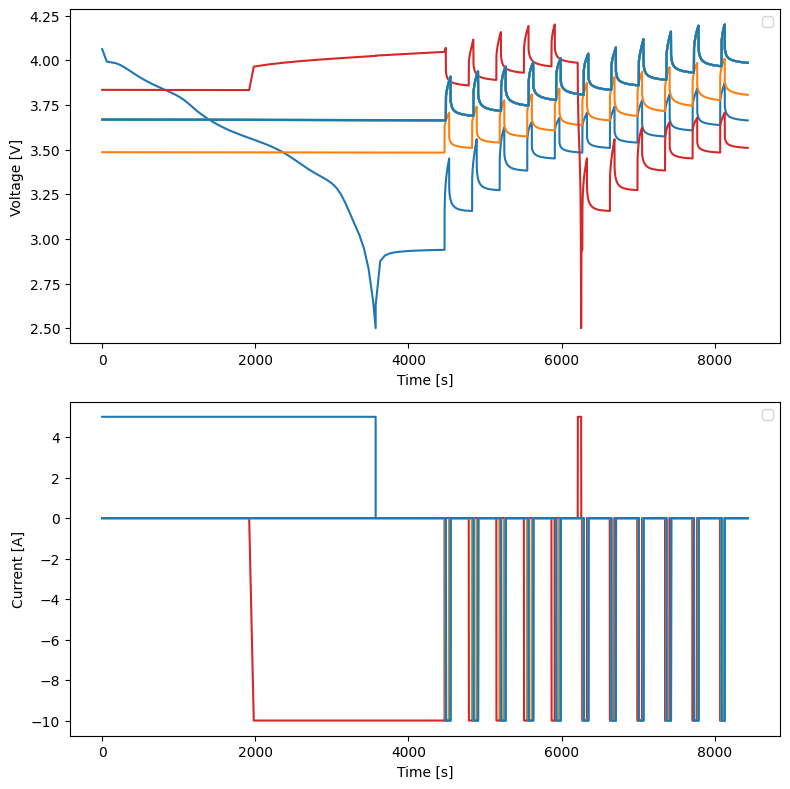

In [39]:
num_entries, solution = fast(n, [])
plot_given_range(solution, 0, num_entries)


In [40]:
_, solution = fast(n, solution)


2023-06-27 07:42:04.357 - [NOTICE] logger.func(15): Cycle 221/221 (130.300 us elapsed) --------------------
2023-06-27 07:42:04.358 - [NOTICE] logger.func(15): Cycle 221/221, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:42:04.402 - [NOTICE] logger.func(15): Cycle 221/221, step 2/2: Rest for 15 minute
2023-06-27 07:42:04.675 - [NOTICE] logger.func(15): Finish experiment simulation, took 314.694 ms
2023-06-27 07:42:05.804 - [NOTICE] logger.func(15): Cycle 222/222 (114.300 us elapsed) --------------------
2023-06-27 07:42:05.805 - [NOTICE] logger.func(15): Cycle 222/222, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:05.850 - [NOTICE] logger.func(15): Cycle 222/222, step 2/2: Rest for 5 minutes
2023-06-27 07:42:06.123 - [NOTICE] logger.func(15): Finish experiment simulation, took 314.544 ms
2023-06-27 07:42:06.949 - [NOTICE] logger.func(15): Cycle 223/223 (132.200 us elapsed) --------------------
2023-06-27 07:42:06.950 - [NOTICE] logger.func(15): Cycle 223/223

360.0


2023-06-27 07:42:07.153 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.519 ms
2023-06-27 07:42:08.024 - [NOTICE] logger.func(15): Cycle 224/224 (89.700 us elapsed) --------------------
2023-06-27 07:42:08.025 - [NOTICE] logger.func(15): Cycle 224/224, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:08.030 - [NOTICE] logger.func(15): Cycle 224/224, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:08.259 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.483 ms
2023-06-27 07:42:09.148 - [NOTICE] logger.func(15): Cycle 225/225 (139.100 us elapsed) --------------------
2023-06-27 07:42:09.149 - [NOTICE] logger.func(15): Cycle 225/225, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:09.152 - [NOTICE] logger.func(15): Cycle 225/225, step 2/2: Rest for 5 minutes
2023-06-27 07:42:09.330 - [NOTICE] logger.func(15): Finish experiment simulation, took 179.813 ms


360.0


2023-06-27 07:42:10.204 - [NOTICE] logger.func(15): Cycle 226/226 (81.600 us elapsed) --------------------
2023-06-27 07:42:10.204 - [NOTICE] logger.func(15): Cycle 226/226, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:10.209 - [NOTICE] logger.func(15): Cycle 226/226, step 2/2: Rest for 5 minutes
2023-06-27 07:42:10.405 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.990 ms


360.0


2023-06-27 07:42:11.309 - [NOTICE] logger.func(15): Cycle 227/227 (82.700 us elapsed) --------------------
2023-06-27 07:42:11.310 - [NOTICE] logger.func(15): Cycle 227/227, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:11.315 - [NOTICE] logger.func(15): Cycle 227/227, step 2/2: Rest for 5 minutes
2023-06-27 07:42:11.499 - [NOTICE] logger.func(15): Finish experiment simulation, took 185.452 ms


360.0


2023-06-27 07:42:12.407 - [NOTICE] logger.func(15): Cycle 228/228 (128.000 us elapsed) --------------------
2023-06-27 07:42:12.408 - [NOTICE] logger.func(15): Cycle 228/228, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:12.412 - [NOTICE] logger.func(15): Cycle 228/228, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:12.618 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.246 ms
2023-06-27 07:42:13.485 - [NOTICE] logger.func(15): Cycle 229/229 (86.700 us elapsed) --------------------
2023-06-27 07:42:13.486 - [NOTICE] logger.func(15): Cycle 229/229, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:13.490 - [NOTICE] logger.func(15): Cycle 229/229, step 2/2: Rest for 5 minutes
2023-06-27 07:42:13.686 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.726 ms


360.0


2023-06-27 07:42:14.693 - [NOTICE] logger.func(15): Cycle 230/230 (91.000 us elapsed) --------------------
2023-06-27 07:42:14.694 - [NOTICE] logger.func(15): Cycle 230/230, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:14.699 - [NOTICE] logger.func(15): Cycle 230/230, step 2/2: Rest for 5 minutes
2023-06-27 07:42:14.908 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.784 ms


360.0


2023-06-27 07:42:15.806 - [NOTICE] logger.func(15): Cycle 231/231 (82.000 us elapsed) --------------------
2023-06-27 07:42:15.807 - [NOTICE] logger.func(15): Cycle 231/231, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:15.811 - [NOTICE] logger.func(15): Cycle 231/231, step 2/2: Rest for 5 minutes
2023-06-27 07:42:15.999 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.281 ms


360.0


2023-06-27 07:42:16.920 - [NOTICE] logger.func(15): Cycle 232/232 (165.500 us elapsed) --------------------
2023-06-27 07:42:16.922 - [NOTICE] logger.func(15): Cycle 232/232, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:16.936 - [NOTICE] logger.func(15): Cycle 232/232, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:17.155 - [NOTICE] logger.func(15): Finish experiment simulation, took 230.709 ms
2023-06-27 07:42:18.078 - [NOTICE] logger.func(15): Cycle 233/233 (84.500 us elapsed) --------------------
2023-06-27 07:42:18.079 - [NOTICE] logger.func(15): Cycle 233/233, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:18.084 - [NOTICE] logger.func(15): Cycle 233/233, step 2/2: Rest for 5 minutes
2023-06-27 07:42:18.259 - [NOTICE] logger.func(15): Finish experiment simulation, took 176.922 ms


360.0


2023-06-27 07:42:19.101 - [NOTICE] logger.func(15): Cycle 234/234 (86.100 us elapsed) --------------------
2023-06-27 07:42:19.102 - [NOTICE] logger.func(15): Cycle 234/234, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:19.106 - [NOTICE] logger.func(15): Cycle 234/234, step 2/2: Rest for 5 minutes
2023-06-27 07:42:19.285 - [NOTICE] logger.func(15): Finish experiment simulation, took 177.846 ms


360.0


2023-06-27 07:42:20.551 - [NOTICE] logger.func(15): Cycle 235/235 (102.200 us elapsed) --------------------
2023-06-27 07:42:20.551 - [NOTICE] logger.func(15): Cycle 235/235, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:20.555 - [NOTICE] logger.func(15): Cycle 235/235, step 2/2: Rest for 5 minutes
2023-06-27 07:42:20.732 - [NOTICE] logger.func(15): Finish experiment simulation, took 176.763 ms


360.0


2023-06-27 07:42:21.623 - [NOTICE] logger.func(15): Cycle 236/236 (120.500 us elapsed) --------------------
2023-06-27 07:42:21.623 - [NOTICE] logger.func(15): Cycle 236/236, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:21.629 - [NOTICE] logger.func(15): Cycle 236/236, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:21.894 - [NOTICE] logger.func(15): Finish experiment simulation, took 265.714 ms
2023-06-27 07:42:22.807 - [NOTICE] logger.func(15): Cycle 237/237 (83.600 us elapsed) --------------------
2023-06-27 07:42:22.807 - [NOTICE] logger.func(15): Cycle 237/237, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:22.812 - [NOTICE] logger.func(15): Cycle 237/237, step 2/2: Rest for 5 minutes
2023-06-27 07:42:22.984 - [NOTICE] logger.func(15): Finish experiment simulation, took 173.100 ms


360.0


2023-06-27 07:42:23.872 - [NOTICE] logger.func(15): Cycle 238/238 (81.100 us elapsed) --------------------
2023-06-27 07:42:23.873 - [NOTICE] logger.func(15): Cycle 238/238, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:23.878 - [NOTICE] logger.func(15): Cycle 238/238, step 2/2: Rest for 5 minutes
2023-06-27 07:42:24.053 - [NOTICE] logger.func(15): Finish experiment simulation, took 176.895 ms


360.0


2023-06-27 07:42:24.920 - [NOTICE] logger.func(15): Cycle 239/239 (137.000 us elapsed) --------------------
2023-06-27 07:42:24.921 - [NOTICE] logger.func(15): Cycle 239/239, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:24.925 - [NOTICE] logger.func(15): Cycle 239/239, step 2/2: Rest for 5 minutes
2023-06-27 07:42:25.121 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.625 ms


360.0


2023-06-27 07:42:26.068 - [NOTICE] logger.func(15): Cycle 240/240 (126.500 us elapsed) --------------------
2023-06-27 07:42:26.070 - [NOTICE] logger.func(15): Cycle 240/240, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:26.074 - [NOTICE] logger.func(15): Cycle 240/240, step 2/2: Rest for 5 minutes
2023-06-27 07:42:26.254 - [NOTICE] logger.func(15): Finish experiment simulation, took 181.691 ms


360.0


2023-06-27 07:42:27.242 - [NOTICE] logger.func(15): Cycle 241/241 (102.900 us elapsed) --------------------
2023-06-27 07:42:27.242 - [NOTICE] logger.func(15): Cycle 241/241, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:27.249 - [NOTICE] logger.func(15): Cycle 241/241, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:27.599 - [NOTICE] logger.func(15): Finish experiment simulation, took 348.240 ms
2023-06-27 07:42:28.796 - [NOTICE] logger.func(15): Cycle 242/242 (94.000 us elapsed) --------------------
2023-06-27 07:42:28.797 - [NOTICE] logger.func(15): Cycle 242/242, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:28.812 - [NOTICE] logger.func(15): Cycle 242/242, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:29.086 - [NOTICE] logger.func(15): Finish experiment simulation, took 283.529 ms
2023-06-27 07:42:30.130 - [NOTICE] logger.func(15): Cycle 243/243 (134.200 us elapsed) --------------------
2023-06-27 07:42:30.131 - [NOTICE] logger.func(15): Cycle 243/243, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:30.142 - [NOTICE] logger.func(15): Cycle 243/243, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:30.434 - [NOTICE] logger.func(15): Finish experiment simulation, took 295.516 ms
2023-06-27 07:42:31.399 - [NOTICE] logger.func(15): Cycle 244/244 (75.400 us elapsed) --------------------
2023-06-27 07:42:31.400 - [NOTICE] logger.func(15): Cycle 244/244, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:42:31.411 - [NOTICE] logger.func(15): Cycle 244/244, step 2/2: Rest for 15 minute
2023-06-27 07:42:31.597 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.110 ms


339.92134322163474


2023-06-27 07:42:32.486 - [NOTICE] logger.func(15): Cycle 245/245 (85.300 us elapsed) --------------------
2023-06-27 07:42:32.488 - [NOTICE] logger.func(15): Cycle 245/245, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:32.492 - [NOTICE] logger.func(15): Cycle 245/245, step 2/2: Rest for 5 minutes
2023-06-27 07:42:32.697 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.470 ms
2023-06-27 07:42:33.618 - [NOTICE] logger.func(15): Cycle 246/246 (183.900 us elapsed) --------------------
2023-06-27 07:42:33.619 - [NOTICE] logger.func(15): Cycle 246/246, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:33.626 - [NOTICE] logger.func(15): Cycle 246/246, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:33.835 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.195 ms
2023-06-27 07:42:34.863 - [NOTICE] logger.func(15): Cycle 247/247 (146.900 us elapsed) --------------------
2023-06-27 07:42:34.864 - [NOTICE] logger.func(15): Cycle 247/247, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:34.872 - [NOTICE] logger.func(15): Cycle 247/247, step 2/2: Rest for 5 minutes
2023-06-27 07:42:35.073 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.384 ms


360.0


2023-06-27 07:42:36.028 - [NOTICE] logger.func(15): Cycle 248/248 (94.700 us elapsed) --------------------
2023-06-27 07:42:36.029 - [NOTICE] logger.func(15): Cycle 248/248, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:36.036 - [NOTICE] logger.func(15): Cycle 248/248, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:36.257 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.195 ms
2023-06-27 07:42:37.300 - [NOTICE] logger.func(15): Cycle 249/249 (147.300 us elapsed) --------------------
2023-06-27 07:42:37.301 - [NOTICE] logger.func(15): Cycle 249/249, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:37.308 - [NOTICE] logger.func(15): Cycle 249/249, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:37.542 - [NOTICE] logger.func(15): Finish experiment simulation, took 237.634 ms
2023-06-27 07:42:38.544 - [NOTICE] logger.func(15): Cycle 250/250 (87.300 us elapsed) --------------------
2023-06-27 07:42:38.545 - [NOTICE] logger.func(15): Cycle 250/250, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:38.550 - [NOTICE] logger.func(15): Cycle 250/250, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:38.781 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.843 ms
2023-06-27 07:42:39.782 - [NOTICE] logger.func(15): Cycle 251/251 (161.700 us elapsed) --------------------
2023-06-27 07:42:39.783 - [NOTICE] logger.func(15): Cycle 251/251, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:39.787 - [NOTICE] logger.func(15): Cycle 251/251, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:40.002 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.970 ms
2023-06-27 07:42:40.995 - [NOTICE] logger.func(15): Cycle 252/252 (89.500 us elapsed) --------------------
2023-06-27 07:42:40.996 - [NOTICE] logger.func(15): Cycle 252/252, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:41.002 - [NOTICE] logger.func(15): Cycle 252/252, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:41.228 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.150 ms
2023-06-27 07:42:42.338 - [NOTICE] logger.func(15): Cycle 253/253 (91.400 us elapsed) --------------------
2023-06-27 07:42:42.339 - [NOTICE] logger.func(15): Cycle 253/253, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:42.345 - [NOTICE] logger.func(15): Cycle 253/253, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:42.553 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.844 ms
2023-06-27 07:42:43.542 - [NOTICE] logger.func(15): Cycle 254/254 (119.200 us elapsed) --------------------
2023-06-27 07:42:43.543 - [NOTICE] logger.func(15): Cycle 254/254, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:43.547 - [NOTICE] logger.func(15): Cycle 254/254, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:43.753 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.555 ms
2023-06-27 07:42:44.744 - [NOTICE] logger.func(15): Cycle 255/255 (360.200 us elapsed) --------------------
2023-06-27 07:42:44.745 - [NOTICE] logger.func(15): Cycle 255/255, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:44.752 - [NOTICE] logger.func(15): Cycle 255/255, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:44.967 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.889 ms
2023-06-27 07:42:45.963 - [NOTICE] logger.func(15): Cycle 256/256 (169.600 us elapsed) --------------------
2023-06-27 07:42:45.964 - [NOTICE] logger.func(15): Cycle 256/256, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:45.971 - [NOTICE] logger.func(15): Cycle 256/256, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:47.451 - [NOTICE] logger.func(15): Finish experiment simulation, took 1.482 s
2023-06-27 07:42:48.462 - [NOTICE] logger.func(15): Cycle 257/257 (88.000 us elapsed) --------------------
2023-06-27 07:42:48.464 - [NOTICE] logger.func(15): Cycle 257/257, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:48.470 - [NOTICE] logger.func(15): Cycle 257/257, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:48.708 - [NOTICE] logger.func(15): Finish experiment simulation, took 241.802 ms
2023-06-27 07:42:49.754 - [NOTICE] logger.func(15): Cycle 258/258 (120.800 us elapsed) --------------------
2023-06-27 07:42:49.754 - [NOTICE] logger.func(15): Cycle 258/258, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:49.763 - [NOTICE] logger.func(15): Cycle 258/258, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:49.989 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.181 ms
2023-06-27 07:42:51.043 - [NOTICE] logger.func(15): Cycle 259/259 (115.400 us elapsed) --------------------
2023-06-27 07:42:51.043 - [NOTICE] logger.func(15): Cycle 259/259, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:51.050 - [NOTICE] logger.func(15): Cycle 259/259, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:51.265 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.025 ms
2023-06-27 07:42:52.282 - [NOTICE] logger.func(15): Cycle 260/260 (90.900 us elapsed) --------------------
2023-06-27 07:42:52.283 - [NOTICE] logger.func(15): Cycle 260/260, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:52.287 - [NOTICE] logger.func(15): Cycle 260/260, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:52.511 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.380 ms
2023-06-27 07:42:53.551 - [NOTICE] logger.func(15): Cycle 261/261 (89.600 us elapsed) --------------------
2023-06-27 07:42:53.554 - [NOTICE] logger.func(15): Cycle 261/261, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:53.563 - [NOTICE] logger.func(15): Cycle 261/261, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:53.828 - [NOTICE] logger.func(15): Finish experiment simulation, took 268.465 ms
2023-06-27 07:42:54.876 - [NOTICE] logger.func(15): Cycle 262/262 (98.600 us elapsed) --------------------
2023-06-27 07:42:54.877 - [NOTICE] logger.func(15): Cycle 262/262, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:54.883 - [NOTICE] logger.func(15): Cycle 262/262, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:55.101 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.468 ms
2023-06-27 07:42:56.117 - [NOTICE] logger.func(15): Cycle 263/263 (105.000 us elapsed) --------------------
2023-06-27 07:42:56.118 - [NOTICE] logger.func(15): Cycle 263/263, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:56.123 - [NOTICE] logger.func(15): Cycle 263/263, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:56.343 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.804 ms
2023-06-27 07:42:57.428 - [NOTICE] logger.func(15): Cycle 264/264 (92.900 us elapsed) --------------------
2023-06-27 07:42:57.429 - [NOTICE] logger.func(15): Cycle 264/264, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:57.437 - [NOTICE] logger.func(15): Cycle 264/264, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:57.708 - [NOTICE] logger.func(15): Finish experiment simulation, took 275.557 ms
2023-06-27 07:42:58.765 - [NOTICE] logger.func(15): Cycle 265/265 (92.000 us elapsed) --------------------
2023-06-27 07:42:58.765 - [NOTICE] logger.func(15): Cycle 265/265, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:42:58.773 - [NOTICE] logger.func(15): Cycle 265/265, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:42:58.983 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.902 ms
2023-06-27 07:43:00.027 - [NOTICE] logger.func(15): Cycle 266/266 (121.200 us elapsed) --------------------
2023-06-27 07:43:00.028 - [NOTICE] logger.func(15): Cycle 266/266, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:00.041 - [NOTICE] logger.func(15): Cycle 266/266, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:00.248 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.448 ms
2023-06-27 07:43:01.323 - [NOTICE] logger.func(15): Cycle 267/267 (92.500 us elapsed) --------------------
2023-06-27 07:43:01.323 - [NOTICE] logger.func(15): Cycle 267/267, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:43:01.339 - [NOTICE] logger.func(15): Cycle 267/267, step 2/2: Rest for 15 minute


339.5769918416627


2023-06-27 07:43:01.599 - [NOTICE] logger.func(15): Finish experiment simulation, took 271.550 ms
2023-06-27 07:43:02.650 - [NOTICE] logger.func(15): Cycle 268/268 (99.900 us elapsed) --------------------
2023-06-27 07:43:02.650 - [NOTICE] logger.func(15): Cycle 268/268, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:02.657 - [NOTICE] logger.func(15): Cycle 268/268, step 2/2: Rest for 5 minutes
2023-06-27 07:43:02.865 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.632 ms
2023-06-27 07:43:03.907 - [NOTICE] logger.func(15): Cycle 269/269 (106.700 us elapsed) --------------------
2023-06-27 07:43:03.908 - [NOTICE] logger.func(15): Cycle 269/269, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:03.915 - [NOTICE] logger.func(15): Cycle 269/269, step 2/2: Rest for 5 minutes
2023-06-27 07:43:04.122 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.532 ms


360.0


2023-06-27 07:43:05.261 - [NOTICE] logger.func(15): Cycle 270/270 (97.400 us elapsed) --------------------
2023-06-27 07:43:05.261 - [NOTICE] logger.func(15): Cycle 270/270, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:05.272 - [NOTICE] logger.func(15): Cycle 270/270, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:05.496 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.415 ms
2023-06-27 07:43:06.570 - [NOTICE] logger.func(15): Cycle 271/271 (177.500 us elapsed) --------------------
2023-06-27 07:43:06.571 - [NOTICE] logger.func(15): Cycle 271/271, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:06.576 - [NOTICE] logger.func(15): Cycle 271/271, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:06.793 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.523 ms
2023-06-27 07:43:07.846 - [NOTICE] logger.func(15): Cycle 272/272 (89.000 us elapsed) --------------------
2023-06-27 07:43:07.847 - [NOTICE] logger.func(15): Cycle 272/272, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:07.853 - [NOTICE] logger.func(15): Cycle 272/272, step 2/2: Rest for 5 minutes
2023-06-27 07:43:08.050 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.940 ms


360.0


2023-06-27 07:43:09.210 - [NOTICE] logger.func(15): Cycle 273/273 (110.100 us elapsed) --------------------
2023-06-27 07:43:09.211 - [NOTICE] logger.func(15): Cycle 273/273, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:09.216 - [NOTICE] logger.func(15): Cycle 273/273, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:09.443 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.755 ms
2023-06-27 07:43:10.568 - [NOTICE] logger.func(15): Cycle 274/274 (85.900 us elapsed) --------------------
2023-06-27 07:43:10.568 - [NOTICE] logger.func(15): Cycle 274/274, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:10.574 - [NOTICE] logger.func(15): Cycle 274/274, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:10.788 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.913 ms
2023-06-27 07:43:11.869 - [NOTICE] logger.func(15): Cycle 275/275 (119.100 us elapsed) --------------------
2023-06-27 07:43:11.870 - [NOTICE] logger.func(15): Cycle 275/275, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:11.875 - [NOTICE] logger.func(15): Cycle 275/275, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:12.091 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.871 ms
2023-06-27 07:43:13.304 - [NOTICE] logger.func(15): Cycle 276/276 (429.500 us elapsed) --------------------
2023-06-27 07:43:13.305 - [NOTICE] logger.func(15): Cycle 276/276, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:13.309 - [NOTICE] logger.func(15): Cycle 276/276, step 2/2: Rest for 5 minutes
2023-06-27 07:43:13.515 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.003 ms


360.0


2023-06-27 07:43:14.654 - [NOTICE] logger.func(15): Cycle 277/277 (122.200 us elapsed) --------------------
2023-06-27 07:43:14.656 - [NOTICE] logger.func(15): Cycle 277/277, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:14.663 - [NOTICE] logger.func(15): Cycle 277/277, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:14.879 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.519 ms
2023-06-27 07:43:16.002 - [NOTICE] logger.func(15): Cycle 278/278 (102.100 us elapsed) --------------------
2023-06-27 07:43:16.003 - [NOTICE] logger.func(15): Cycle 278/278, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:16.008 - [NOTICE] logger.func(15): Cycle 278/278, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:16.223 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.668 ms
2023-06-27 07:43:17.420 - [NOTICE] logger.func(15): Cycle 279/279 (124.200 us elapsed) --------------------
2023-06-27 07:43:17.421 - [NOTICE] logger.func(15): Cycle 279/279, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:17.429 - [NOTICE] logger.func(15): Cycle 279/279, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:17.656 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.775 ms
2023-06-27 07:43:18.817 - [NOTICE] logger.func(15): Cycle 280/280 (141.100 us elapsed) --------------------
2023-06-27 07:43:18.818 - [NOTICE] logger.func(15): Cycle 280/280, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:18.824 - [NOTICE] logger.func(15): Cycle 280/280, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:19.034 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.745 ms
2023-06-27 07:43:20.193 - [NOTICE] logger.func(15): Cycle 281/281 (116.000 us elapsed) --------------------
2023-06-27 07:43:20.193 - [NOTICE] logger.func(15): Cycle 281/281, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:20.197 - [NOTICE] logger.func(15): Cycle 281/281, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:20.406 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.728 ms
2023-06-27 07:43:21.526 - [NOTICE] logger.func(15): Cycle 282/282 (146.400 us elapsed) --------------------
2023-06-27 07:43:21.527 - [NOTICE] logger.func(15): Cycle 282/282, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:21.533 - [NOTICE] logger.func(15): Cycle 282/282, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:21.742 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.552 ms
2023-06-27 07:43:22.928 - [NOTICE] logger.func(15): Cycle 283/283 (89.900 us elapsed) --------------------
2023-06-27 07:43:22.929 - [NOTICE] logger.func(15): Cycle 283/283, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:22.935 - [NOTICE] logger.func(15): Cycle 283/283, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:23.156 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.576 ms
2023-06-27 07:43:24.289 - [NOTICE] logger.func(15): Cycle 284/284 (84.000 us elapsed) --------------------
2023-06-27 07:43:24.290 - [NOTICE] logger.func(15): Cycle 284/284, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:24.295 - [NOTICE] logger.func(15): Cycle 284/284, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:24.501 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.305 ms
2023-06-27 07:43:25.708 - [NOTICE] logger.func(15): Cycle 285/285 (215.200 us elapsed) --------------------
2023-06-27 07:43:25.709 - [NOTICE] logger.func(15): Cycle 285/285, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:25.716 - [NOTICE] logger.func(15): Cycle 285/285, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:26.491 - [NOTICE] logger.func(15): Finish experiment simulation, took 778.564 ms
2023-06-27 07:43:27.658 - [NOTICE] logger.func(15): Cycle 286/286 (179.700 us elapsed) --------------------
2023-06-27 07:43:27.659 - [NOTICE] logger.func(15): Cycle 286/286, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:27.664 - [NOTICE] logger.func(15): Cycle 286/286, step 2/2: Rest for 5 minutes
2023-06-27 07:43:27.873 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.738 ms


360.0


2023-06-27 07:43:29.101 - [NOTICE] logger.func(15): Cycle 287/287 (132.500 us elapsed) --------------------
2023-06-27 07:43:29.102 - [NOTICE] logger.func(15): Cycle 287/287, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:29.110 - [NOTICE] logger.func(15): Cycle 287/287, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:29.342 - [NOTICE] logger.func(15): Finish experiment simulation, took 235.803 ms
2023-06-27 07:43:30.498 - [NOTICE] logger.func(15): Cycle 288/288 (108.300 us elapsed) --------------------
2023-06-27 07:43:30.498 - [NOTICE] logger.func(15): Cycle 288/288, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:30.505 - [NOTICE] logger.func(15): Cycle 288/288, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:30.719 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.924 ms
2023-06-27 07:43:31.843 - [NOTICE] logger.func(15): Cycle 289/289 (94.100 us elapsed) --------------------
2023-06-27 07:43:31.843 - [NOTICE] logger.func(15): Cycle 289/289, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:31.852 - [NOTICE] logger.func(15): Cycle 289/289, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:32.077 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.382 ms
2023-06-27 07:43:33.290 - [NOTICE] logger.func(15): Cycle 290/290 (89.600 us elapsed) --------------------
2023-06-27 07:43:33.292 - [NOTICE] logger.func(15): Cycle 290/290, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:43:33.307 - [NOTICE] logger.func(15): Cycle 290/290, step 2/2: Rest for 15 minute


339.23532827131567


2023-06-27 07:43:33.527 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.363 ms
2023-06-27 07:43:34.704 - [NOTICE] logger.func(15): Cycle 291/291 (125.700 us elapsed) --------------------
2023-06-27 07:43:34.705 - [NOTICE] logger.func(15): Cycle 291/291, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:34.712 - [NOTICE] logger.func(15): Cycle 291/291, step 2/2: Rest for 5 minutes
2023-06-27 07:43:34.922 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.084 ms
2023-06-27 07:43:36.094 - [NOTICE] logger.func(15): Cycle 292/292 (86.200 us elapsed) --------------------
2023-06-27 07:43:36.095 - [NOTICE] logger.func(15): Cycle 292/292, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:36.100 - [NOTICE] logger.func(15): Cycle 292/292, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:36.303 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.853 ms
2023-06-27 07:43:37.628 - [NOTICE] logger.func(15): Cycle 293/293 (94.000 us elapsed) --------------------
2023-06-27 07:43:37.629 - [NOTICE] logger.func(15): Cycle 293/293, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:37.635 - [NOTICE] logger.func(15): Cycle 293/293, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:37.845 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.828 ms
2023-06-27 07:43:39.090 - [NOTICE] logger.func(15): Cycle 294/294 (88.300 us elapsed) --------------------
2023-06-27 07:43:39.091 - [NOTICE] logger.func(15): Cycle 294/294, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:39.097 - [NOTICE] logger.func(15): Cycle 294/294, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:39.319 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.500 ms
2023-06-27 07:43:40.485 - [NOTICE] logger.func(15): Cycle 295/295 (194.100 us elapsed) --------------------
2023-06-27 07:43:40.487 - [NOTICE] logger.func(15): Cycle 295/295, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:40.494 - [NOTICE] logger.func(15): Cycle 295/295, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:40.727 - [NOTICE] logger.func(15): Finish experiment simulation, took 236.278 ms
2023-06-27 07:43:41.963 - [NOTICE] logger.func(15): Cycle 296/296 (119.700 us elapsed) --------------------
2023-06-27 07:43:41.964 - [NOTICE] logger.func(15): Cycle 296/296, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:41.968 - [NOTICE] logger.func(15): Cycle 296/296, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:42.221 - [NOTICE] logger.func(15): Finish experiment simulation, took 252.765 ms
2023-06-27 07:43:43.394 - [NOTICE] logger.func(15): Cycle 297/297 (92.400 us elapsed) --------------------
2023-06-27 07:43:43.394 - [NOTICE] logger.func(15): Cycle 297/297, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:43.400 - [NOTICE] logger.func(15): Cycle 297/297, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:43.606 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.207 ms
2023-06-27 07:43:44.836 - [NOTICE] logger.func(15): Cycle 298/298 (108.100 us elapsed) --------------------
2023-06-27 07:43:44.836 - [NOTICE] logger.func(15): Cycle 298/298, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:44.844 - [NOTICE] logger.func(15): Cycle 298/298, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:45.065 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.575 ms
2023-06-27 07:43:46.314 - [NOTICE] logger.func(15): Cycle 299/299 (130.200 us elapsed) --------------------
2023-06-27 07:43:46.315 - [NOTICE] logger.func(15): Cycle 299/299, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:46.322 - [NOTICE] logger.func(15): Cycle 299/299, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:46.617 - [NOTICE] logger.func(15): Finish experiment simulation, took 294.834 ms
2023-06-27 07:43:47.819 - [NOTICE] logger.func(15): Cycle 300/300 (85.800 us elapsed) --------------------
2023-06-27 07:43:47.820 - [NOTICE] logger.func(15): Cycle 300/300, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:47.825 - [NOTICE] logger.func(15): Cycle 300/300, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:48.041 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.167 ms
2023-06-27 07:43:49.311 - [NOTICE] logger.func(15): Cycle 301/301 (91.600 us elapsed) --------------------
2023-06-27 07:43:49.311 - [NOTICE] logger.func(15): Cycle 301/301, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:49.318 - [NOTICE] logger.func(15): Cycle 301/301, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:49.544 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.460 ms
2023-06-27 07:43:50.785 - [NOTICE] logger.func(15): Cycle 302/302 (267.400 us elapsed) --------------------
2023-06-27 07:43:50.786 - [NOTICE] logger.func(15): Cycle 302/302, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:50.791 - [NOTICE] logger.func(15): Cycle 302/302, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:51.050 - [NOTICE] logger.func(15): Finish experiment simulation, took 259.152 ms
2023-06-27 07:43:52.292 - [NOTICE] logger.func(15): Cycle 303/303 (94.700 us elapsed) --------------------
2023-06-27 07:43:52.293 - [NOTICE] logger.func(15): Cycle 303/303, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:52.298 - [NOTICE] logger.func(15): Cycle 303/303, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:52.517 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.327 ms
2023-06-27 07:43:53.863 - [NOTICE] logger.func(15): Cycle 304/304 (97.100 us elapsed) --------------------
2023-06-27 07:43:53.863 - [NOTICE] logger.func(15): Cycle 304/304, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:53.870 - [NOTICE] logger.func(15): Cycle 304/304, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:54.090 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.447 ms
2023-06-27 07:43:55.388 - [NOTICE] logger.func(15): Cycle 305/305 (90.600 us elapsed) --------------------
2023-06-27 07:43:55.389 - [NOTICE] logger.func(15): Cycle 305/305, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:55.394 - [NOTICE] logger.func(15): Cycle 305/305, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:55.618 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.798 ms
2023-06-27 07:43:56.912 - [NOTICE] logger.func(15): Cycle 306/306 (129.400 us elapsed) --------------------
2023-06-27 07:43:56.913 - [NOTICE] logger.func(15): Cycle 306/306, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:56.920 - [NOTICE] logger.func(15): Cycle 306/306, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:57.149 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.230 ms
2023-06-27 07:43:58.497 - [NOTICE] logger.func(15): Cycle 307/307 (130.900 us elapsed) --------------------
2023-06-27 07:43:58.498 - [NOTICE] logger.func(15): Cycle 307/307, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:58.503 - [NOTICE] logger.func(15): Cycle 307/307, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:43:58.711 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.506 ms
2023-06-27 07:43:59.982 - [NOTICE] logger.func(15): Cycle 308/308 (89.400 us elapsed) --------------------
2023-06-27 07:43:59.984 - [NOTICE] logger.func(15): Cycle 308/308, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:43:59.989 - [NOTICE] logger.func(15): Cycle 308/308, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:00.217 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.560 ms
2023-06-27 07:44:01.527 - [NOTICE] logger.func(15): Cycle 309/309 (142.500 us elapsed) --------------------
2023-06-27 07:44:01.528 - [NOTICE] logger.func(15): Cycle 309/309, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:01.534 - [NOTICE] logger.func(15): Cycle 309/309, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:01.741 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.731 ms
2023-06-27 07:44:03.057 - [NOTICE] logger.func(15): Cycle 310/310 (199.200 us elapsed) --------------------
2023-06-27 07:44:03.059 - [NOTICE] logger.func(15): Cycle 310/310, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:03.064 - [NOTICE] logger.func(15): Cycle 310/310, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:03.310 - [NOTICE] logger.func(15): Finish experiment simulation, took 246.536 ms
2023-06-27 07:44:04.587 - [NOTICE] logger.func(15): Cycle 311/311 (88.200 us elapsed) --------------------
2023-06-27 07:44:04.588 - [NOTICE] logger.func(15): Cycle 311/311, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:04.594 - [NOTICE] logger.func(15): Cycle 311/311, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:04.828 - [NOTICE] logger.func(15): Finish experiment simulation, took 235.187 ms
2023-06-27 07:44:06.119 - [NOTICE] logger.func(15): Cycle 312/312 (93.900 us elapsed) --------------------
2023-06-27 07:44:06.119 - [NOTICE] logger.func(15): Cycle 312/312, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:06.128 - [NOTICE] logger.func(15): Cycle 312/312, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:06.356 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.616 ms
2023-06-27 07:44:07.654 - [NOTICE] logger.func(15): Cycle 313/313 (77.700 us elapsed) --------------------
2023-06-27 07:44:07.655 - [NOTICE] logger.func(15): Cycle 313/313, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:44:07.668 - [NOTICE] logger.func(15): Cycle 313/313, step 2/2: Rest for 15 minute


338.8970541943854


2023-06-27 07:44:07.901 - [NOTICE] logger.func(15): Finish experiment simulation, took 239.417 ms
2023-06-27 07:44:09.168 - [NOTICE] logger.func(15): Cycle 314/314 (151.900 us elapsed) --------------------
2023-06-27 07:44:09.170 - [NOTICE] logger.func(15): Cycle 314/314, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:09.175 - [NOTICE] logger.func(15): Cycle 314/314, step 2/2: Rest for 5 minutes
2023-06-27 07:44:09.394 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.239 ms
2023-06-27 07:44:10.728 - [NOTICE] logger.func(15): Cycle 315/315 (107.400 us elapsed) --------------------
2023-06-27 07:44:10.729 - [NOTICE] logger.func(15): Cycle 315/315, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:10.735 - [NOTICE] logger.func(15): Cycle 315/315, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:10.944 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.585 ms
2023-06-27 07:44:12.212 - [NOTICE] logger.func(15): Cycle 316/316 (90.000 us elapsed) --------------------
2023-06-27 07:44:12.212 - [NOTICE] logger.func(15): Cycle 316/316, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:12.218 - [NOTICE] logger.func(15): Cycle 316/316, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:12.448 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.799 ms
2023-06-27 07:44:13.751 - [NOTICE] logger.func(15): Cycle 317/317 (143.000 us elapsed) --------------------
2023-06-27 07:44:13.751 - [NOTICE] logger.func(15): Cycle 317/317, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:13.757 - [NOTICE] logger.func(15): Cycle 317/317, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:13.976 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.671 ms
2023-06-27 07:44:15.320 - [NOTICE] logger.func(15): Cycle 318/318 (124.400 us elapsed) --------------------
2023-06-27 07:44:15.320 - [NOTICE] logger.func(15): Cycle 318/318, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:15.325 - [NOTICE] logger.func(15): Cycle 318/318, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:15.528 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.049 ms
2023-06-27 07:44:16.839 - [NOTICE] logger.func(15): Cycle 319/319 (105.600 us elapsed) --------------------
2023-06-27 07:44:16.840 - [NOTICE] logger.func(15): Cycle 319/319, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:16.848 - [NOTICE] logger.func(15): Cycle 319/319, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:17.684 - [NOTICE] logger.func(15): Finish experiment simulation, took 839.991 ms
2023-06-27 07:44:19.086 - [NOTICE] logger.func(15): Cycle 320/320 (87.600 us elapsed) --------------------
2023-06-27 07:44:19.087 - [NOTICE] logger.func(15): Cycle 320/320, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:19.092 - [NOTICE] logger.func(15): Cycle 320/320, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:19.308 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.901 ms
2023-06-27 07:44:20.663 - [NOTICE] logger.func(15): Cycle 321/321 (104.400 us elapsed) --------------------
2023-06-27 07:44:20.665 - [NOTICE] logger.func(15): Cycle 321/321, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:20.671 - [NOTICE] logger.func(15): Cycle 321/321, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:20.900 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.217 ms
2023-06-27 07:44:22.249 - [NOTICE] logger.func(15): Cycle 322/322 (102.500 us elapsed) --------------------
2023-06-27 07:44:22.249 - [NOTICE] logger.func(15): Cycle 322/322, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:22.255 - [NOTICE] logger.func(15): Cycle 322/322, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:22.480 - [NOTICE] logger.func(15): Finish experiment simulation, took 226.857 ms
2023-06-27 07:44:23.804 - [NOTICE] logger.func(15): Cycle 323/323 (136.400 us elapsed) --------------------
2023-06-27 07:44:23.805 - [NOTICE] logger.func(15): Cycle 323/323, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:23.810 - [NOTICE] logger.func(15): Cycle 323/323, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:24.033 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.216 ms
2023-06-27 07:44:25.406 - [NOTICE] logger.func(15): Cycle 324/324 (237.300 us elapsed) --------------------
2023-06-27 07:44:25.407 - [NOTICE] logger.func(15): Cycle 324/324, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:25.413 - [NOTICE] logger.func(15): Cycle 324/324, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:25.625 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.196 ms
2023-06-27 07:44:26.987 - [NOTICE] logger.func(15): Cycle 325/325 (123.400 us elapsed) --------------------
2023-06-27 07:44:26.988 - [NOTICE] logger.func(15): Cycle 325/325, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:26.994 - [NOTICE] logger.func(15): Cycle 325/325, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:27.220 - [NOTICE] logger.func(15): Finish experiment simulation, took 227.766 ms
2023-06-27 07:44:28.566 - [NOTICE] logger.func(15): Cycle 326/326 (122.500 us elapsed) --------------------
2023-06-27 07:44:28.567 - [NOTICE] logger.func(15): Cycle 326/326, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:28.573 - [NOTICE] logger.func(15): Cycle 326/326, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:28.802 - [NOTICE] logger.func(15): Finish experiment simulation, took 230.229 ms
2023-06-27 07:44:30.177 - [NOTICE] logger.func(15): Cycle 327/327 (136.200 us elapsed) --------------------
2023-06-27 07:44:30.178 - [NOTICE] logger.func(15): Cycle 327/327, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:30.184 - [NOTICE] logger.func(15): Cycle 327/327, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:30.396 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.339 ms
2023-06-27 07:44:31.718 - [NOTICE] logger.func(15): Cycle 328/328 (86.100 us elapsed) --------------------
2023-06-27 07:44:31.719 - [NOTICE] logger.func(15): Cycle 328/328, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:31.725 - [NOTICE] logger.func(15): Cycle 328/328, step 2/2: Rest for 5 minutes
2023-06-27 07:44:31.936 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.323 ms


360.0


2023-06-27 07:44:33.318 - [NOTICE] logger.func(15): Cycle 329/329 (126.400 us elapsed) --------------------
2023-06-27 07:44:33.319 - [NOTICE] logger.func(15): Cycle 329/329, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:33.323 - [NOTICE] logger.func(15): Cycle 329/329, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:33.556 - [NOTICE] logger.func(15): Finish experiment simulation, took 232.377 ms
2023-06-27 07:44:34.887 - [NOTICE] logger.func(15): Cycle 330/330 (98.100 us elapsed) --------------------
2023-06-27 07:44:34.888 - [NOTICE] logger.func(15): Cycle 330/330, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:34.893 - [NOTICE] logger.func(15): Cycle 330/330, step 2/2: Rest for 5 minutes
2023-06-27 07:44:35.098 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.410 ms


360.0


2023-06-27 07:44:36.363 - [NOTICE] logger.func(15): Cycle 331/331 (113.600 us elapsed) --------------------
2023-06-27 07:44:36.364 - [NOTICE] logger.func(15): Cycle 331/331, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:36.370 - [NOTICE] logger.func(15): Cycle 331/331, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:36.603 - [NOTICE] logger.func(15): Finish experiment simulation, took 233.716 ms
2023-06-27 07:44:37.993 - [NOTICE] logger.func(15): Cycle 332/332 (102.200 us elapsed) --------------------
2023-06-27 07:44:37.993 - [NOTICE] logger.func(15): Cycle 332/332, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:37.998 - [NOTICE] logger.func(15): Cycle 332/332, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:38.216 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.393 ms
2023-06-27 07:44:39.566 - [NOTICE] logger.func(15): Cycle 333/333 (137.500 us elapsed) --------------------
2023-06-27 07:44:39.566 - [NOTICE] logger.func(15): Cycle 333/333, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:39.572 - [NOTICE] logger.func(15): Cycle 333/333, step 2/2: Rest for 5 minutes
2023-06-27 07:44:39.776 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.781 ms


360.0


2023-06-27 07:44:41.091 - [NOTICE] logger.func(15): Cycle 334/334 (88.600 us elapsed) --------------------
2023-06-27 07:44:41.092 - [NOTICE] logger.func(15): Cycle 334/334, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:41.097 - [NOTICE] logger.func(15): Cycle 334/334, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:41.313 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.686 ms
2023-06-27 07:44:42.646 - [NOTICE] logger.func(15): Cycle 335/335 (89.200 us elapsed) --------------------
2023-06-27 07:44:42.648 - [NOTICE] logger.func(15): Cycle 335/335, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:42.658 - [NOTICE] logger.func(15): Cycle 335/335, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:42.876 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.585 ms
2023-06-27 07:44:44.180 - [NOTICE] logger.func(15): Cycle 336/336 (104.300 us elapsed) --------------------
2023-06-27 07:44:44.181 - [NOTICE] logger.func(15): Cycle 336/336, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:44:44.192 - [NOTICE] logger.func(15): Cycle 336/336, step 2/2: Rest for 15 minute


338.5607832005189


2023-06-27 07:44:44.442 - [NOTICE] logger.func(15): Finish experiment simulation, took 256.245 ms
2023-06-27 07:44:45.773 - [NOTICE] logger.func(15): Cycle 337/337 (87.400 us elapsed) --------------------
2023-06-27 07:44:45.774 - [NOTICE] logger.func(15): Cycle 337/337, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:45.780 - [NOTICE] logger.func(15): Cycle 337/337, step 2/2: Rest for 5 minutes
2023-06-27 07:44:46.000 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.030 ms
2023-06-27 07:44:47.325 - [NOTICE] logger.func(15): Cycle 338/338 (185.800 us elapsed) --------------------
2023-06-27 07:44:47.327 - [NOTICE] logger.func(15): Cycle 338/338, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:47.332 - [NOTICE] logger.func(15): Cycle 338/338, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:47.553 - [NOTICE] logger.func(15): Finish experiment simulation, took 222.388 ms
2023-06-27 07:44:48.936 - [NOTICE] logger.func(15): Cycle 339/339 (178.900 us elapsed) --------------------
2023-06-27 07:44:48.937 - [NOTICE] logger.func(15): Cycle 339/339, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:48.943 - [NOTICE] logger.func(15): Cycle 339/339, step 2/2: Rest for 5 minutes
2023-06-27 07:44:49.158 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.072 ms


360.0


2023-06-27 07:44:50.485 - [NOTICE] logger.func(15): Cycle 340/340 (126.100 us elapsed) --------------------
2023-06-27 07:44:50.486 - [NOTICE] logger.func(15): Cycle 340/340, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:50.492 - [NOTICE] logger.func(15): Cycle 340/340, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:50.709 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.655 ms
2023-06-27 07:44:52.017 - [NOTICE] logger.func(15): Cycle 341/341 (87.200 us elapsed) --------------------
2023-06-27 07:44:52.018 - [NOTICE] logger.func(15): Cycle 341/341, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:52.023 - [NOTICE] logger.func(15): Cycle 341/341, step 2/2: Rest for 5 minutes
2023-06-27 07:44:52.226 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.475 ms


360.0


2023-06-27 07:44:53.649 - [NOTICE] logger.func(15): Cycle 342/342 (136.600 us elapsed) --------------------
2023-06-27 07:44:53.650 - [NOTICE] logger.func(15): Cycle 342/342, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:53.654 - [NOTICE] logger.func(15): Cycle 342/342, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:53.869 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.402 ms
2023-06-27 07:44:55.222 - [NOTICE] logger.func(15): Cycle 343/343 (177.600 us elapsed) --------------------
2023-06-27 07:44:55.222 - [NOTICE] logger.func(15): Cycle 343/343, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:55.228 - [NOTICE] logger.func(15): Cycle 343/343, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:55.430 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.367 ms
2023-06-27 07:44:56.748 - [NOTICE] logger.func(15): Cycle 344/344 (100.300 us elapsed) --------------------
2023-06-27 07:44:56.749 - [NOTICE] logger.func(15): Cycle 344/344, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:56.755 - [NOTICE] logger.func(15): Cycle 344/344, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:44:57.036 - [NOTICE] logger.func(15): Finish experiment simulation, took 280.303 ms
2023-06-27 07:44:58.391 - [NOTICE] logger.func(15): Cycle 345/345 (91.200 us elapsed) --------------------
2023-06-27 07:44:58.392 - [NOTICE] logger.func(15): Cycle 345/345, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:58.398 - [NOTICE] logger.func(15): Cycle 345/345, step 2/2: Rest for 5 minutes
2023-06-27 07:44:58.605 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.680 ms


360.0


2023-06-27 07:44:59.915 - [NOTICE] logger.func(15): Cycle 346/346 (221.900 us elapsed) --------------------
2023-06-27 07:44:59.916 - [NOTICE] logger.func(15): Cycle 346/346, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:44:59.920 - [NOTICE] logger.func(15): Cycle 346/346, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:00.189 - [NOTICE] logger.func(15): Finish experiment simulation, took 265.813 ms
2023-06-27 07:45:01.568 - [NOTICE] logger.func(15): Cycle 347/347 (211.300 us elapsed) --------------------
2023-06-27 07:45:01.569 - [NOTICE] logger.func(15): Cycle 347/347, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:01.574 - [NOTICE] logger.func(15): Cycle 347/347, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:01.778 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.819 ms
2023-06-27 07:45:03.105 - [NOTICE] logger.func(15): Cycle 348/348 (180.500 us elapsed) --------------------
2023-06-27 07:45:03.106 - [NOTICE] logger.func(15): Cycle 348/348, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:03.111 - [NOTICE] logger.func(15): Cycle 348/348, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:03.324 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.814 ms
2023-06-27 07:45:04.738 - [NOTICE] logger.func(15): Cycle 349/349 (131.500 us elapsed) --------------------
2023-06-27 07:45:04.739 - [NOTICE] logger.func(15): Cycle 349/349, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:04.744 - [NOTICE] logger.func(15): Cycle 349/349, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:04.963 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.306 ms
2023-06-27 07:45:06.355 - [NOTICE] logger.func(15): Cycle 350/350 (130.200 us elapsed) --------------------
2023-06-27 07:45:06.356 - [NOTICE] logger.func(15): Cycle 350/350, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:06.361 - [NOTICE] logger.func(15): Cycle 350/350, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:06.571 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.208 ms
2023-06-27 07:45:07.970 - [NOTICE] logger.func(15): Cycle 351/351 (90.600 us elapsed) --------------------
2023-06-27 07:45:07.970 - [NOTICE] logger.func(15): Cycle 351/351, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:07.974 - [NOTICE] logger.func(15): Cycle 351/351, step 2/2: Rest for 5 minutes
2023-06-27 07:45:08.174 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.239 ms


360.0


2023-06-27 07:45:09.559 - [NOTICE] logger.func(15): Cycle 352/352 (193.500 us elapsed) --------------------
2023-06-27 07:45:09.559 - [NOTICE] logger.func(15): Cycle 352/352, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:09.566 - [NOTICE] logger.func(15): Cycle 352/352, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:09.782 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.783 ms
2023-06-27 07:45:11.130 - [NOTICE] logger.func(15): Cycle 353/353 (88.900 us elapsed) --------------------
2023-06-27 07:45:11.130 - [NOTICE] logger.func(15): Cycle 353/353, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:11.135 - [NOTICE] logger.func(15): Cycle 353/353, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:11.344 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.120 ms
2023-06-27 07:45:12.783 - [NOTICE] logger.func(15): Cycle 354/354 (128.000 us elapsed) --------------------
2023-06-27 07:45:12.784 - [NOTICE] logger.func(15): Cycle 354/354, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:12.788 - [NOTICE] logger.func(15): Cycle 354/354, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:13.010 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.808 ms
2023-06-27 07:45:14.408 - [NOTICE] logger.func(15): Cycle 355/355 (94.900 us elapsed) --------------------
2023-06-27 07:45:14.409 - [NOTICE] logger.func(15): Cycle 355/355, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:14.413 - [NOTICE] logger.func(15): Cycle 355/355, step 2/2: Rest for 5 minutes
2023-06-27 07:45:14.613 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.959 ms


360.0


2023-06-27 07:45:15.993 - [NOTICE] logger.func(15): Cycle 356/356 (90.400 us elapsed) --------------------
2023-06-27 07:45:15.994 - [NOTICE] logger.func(15): Cycle 356/356, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:15.999 - [NOTICE] logger.func(15): Cycle 356/356, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:16.226 - [NOTICE] logger.func(15): Finish experiment simulation, took 225.868 ms
2023-06-27 07:45:17.675 - [NOTICE] logger.func(15): Cycle 357/357 (141.000 us elapsed) --------------------
2023-06-27 07:45:17.675 - [NOTICE] logger.func(15): Cycle 357/357, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:17.679 - [NOTICE] logger.func(15): Cycle 357/357, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:17.896 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.751 ms
2023-06-27 07:45:19.308 - [NOTICE] logger.func(15): Cycle 358/358 (87.600 us elapsed) --------------------
2023-06-27 07:45:19.309 - [NOTICE] logger.func(15): Cycle 358/358, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:19.315 - [NOTICE] logger.func(15): Cycle 358/358, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:20.149 - [NOTICE] logger.func(15): Finish experiment simulation, took 833.267 ms
2023-06-27 07:45:21.600 - [NOTICE] logger.func(15): Cycle 359/359 (103.000 us elapsed) --------------------
2023-06-27 07:45:21.601 - [NOTICE] logger.func(15): Cycle 359/359, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:45:21.611 - [NOTICE] logger.func(15): Cycle 359/359, step 2/2: Rest for 15 minute


338.2270912154345


2023-06-27 07:45:21.819 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.307 ms
2023-06-27 07:45:23.281 - [NOTICE] logger.func(15): Cycle 360/360 (89.600 us elapsed) --------------------
2023-06-27 07:45:23.282 - [NOTICE] logger.func(15): Cycle 360/360, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:23.287 - [NOTICE] logger.func(15): Cycle 360/360, step 2/2: Rest for 5 minutes
2023-06-27 07:45:23.505 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.932 ms
2023-06-27 07:45:24.958 - [NOTICE] logger.func(15): Cycle 361/361 (132.100 us elapsed) --------------------
2023-06-27 07:45:24.958 - [NOTICE] logger.func(15): Cycle 361/361, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:24.962 - [NOTICE] logger.func(15): Cycle 361/361, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:25.184 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.531 ms
2023-06-27 07:45:26.606 - [NOTICE] logger.func(15): Cycle 362/362 (84.400 us elapsed) --------------------
2023-06-27 07:45:26.606 - [NOTICE] logger.func(15): Cycle 362/362, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:26.612 - [NOTICE] logger.func(15): Cycle 362/362, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:26.823 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.569 ms
2023-06-27 07:45:28.232 - [NOTICE] logger.func(15): Cycle 363/363 (131.000 us elapsed) --------------------
2023-06-27 07:45:28.233 - [NOTICE] logger.func(15): Cycle 363/363, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:28.237 - [NOTICE] logger.func(15): Cycle 363/363, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:28.455 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.480 ms
2023-06-27 07:45:29.968 - [NOTICE] logger.func(15): Cycle 364/364 (143.600 us elapsed) --------------------
2023-06-27 07:45:29.969 - [NOTICE] logger.func(15): Cycle 364/364, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:29.975 - [NOTICE] logger.func(15): Cycle 364/364, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:30.181 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.244 ms
2023-06-27 07:45:31.597 - [NOTICE] logger.func(15): Cycle 365/365 (97.200 us elapsed) --------------------
2023-06-27 07:45:31.598 - [NOTICE] logger.func(15): Cycle 365/365, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:31.602 - [NOTICE] logger.func(15): Cycle 365/365, step 2/2: Rest for 5 minutes
2023-06-27 07:45:31.803 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.163 ms


360.0


2023-06-27 07:45:33.248 - [NOTICE] logger.func(15): Cycle 366/366 (138.800 us elapsed) --------------------
2023-06-27 07:45:33.249 - [NOTICE] logger.func(15): Cycle 366/366, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:33.253 - [NOTICE] logger.func(15): Cycle 366/366, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:33.474 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.777 ms
2023-06-27 07:45:34.985 - [NOTICE] logger.func(15): Cycle 367/367 (131.100 us elapsed) --------------------
2023-06-27 07:45:34.985 - [NOTICE] logger.func(15): Cycle 367/367, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:34.990 - [NOTICE] logger.func(15): Cycle 367/367, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:35.196 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.420 ms
2023-06-27 07:45:36.636 - [NOTICE] logger.func(15): Cycle 368/368 (99.000 us elapsed) --------------------
2023-06-27 07:45:36.636 - [NOTICE] logger.func(15): Cycle 368/368, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:36.641 - [NOTICE] logger.func(15): Cycle 368/368, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:36.854 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.751 ms
2023-06-27 07:45:38.336 - [NOTICE] logger.func(15): Cycle 369/369 (111.600 us elapsed) --------------------
2023-06-27 07:45:38.336 - [NOTICE] logger.func(15): Cycle 369/369, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:38.342 - [NOTICE] logger.func(15): Cycle 369/369, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:38.567 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.076 ms
2023-06-27 07:45:40.027 - [NOTICE] logger.func(15): Cycle 370/370 (181.900 us elapsed) --------------------
2023-06-27 07:45:40.027 - [NOTICE] logger.func(15): Cycle 370/370, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:40.032 - [NOTICE] logger.func(15): Cycle 370/370, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:40.239 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.980 ms
2023-06-27 07:45:41.725 - [NOTICE] logger.func(15): Cycle 371/371 (91.400 us elapsed) --------------------
2023-06-27 07:45:41.725 - [NOTICE] logger.func(15): Cycle 371/371, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:41.729 - [NOTICE] logger.func(15): Cycle 371/371, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:41.936 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.187 ms
2023-06-27 07:45:43.374 - [NOTICE] logger.func(15): Cycle 372/372 (111.300 us elapsed) --------------------
2023-06-27 07:45:43.374 - [NOTICE] logger.func(15): Cycle 372/372, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:43.380 - [NOTICE] logger.func(15): Cycle 372/372, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:43.590 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.897 ms
2023-06-27 07:45:45.119 - [NOTICE] logger.func(15): Cycle 373/373 (95.700 us elapsed) --------------------
2023-06-27 07:45:45.120 - [NOTICE] logger.func(15): Cycle 373/373, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:45.125 - [NOTICE] logger.func(15): Cycle 373/373, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:45.334 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.161 ms
2023-06-27 07:45:46.826 - [NOTICE] logger.func(15): Cycle 374/374 (91.000 us elapsed) --------------------
2023-06-27 07:45:46.827 - [NOTICE] logger.func(15): Cycle 374/374, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:46.831 - [NOTICE] logger.func(15): Cycle 374/374, step 2/2: Rest for 5 minutes
2023-06-27 07:45:47.036 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.746 ms


360.0


2023-06-27 07:45:48.499 - [NOTICE] logger.func(15): Cycle 375/375 (91.400 us elapsed) --------------------
2023-06-27 07:45:48.500 - [NOTICE] logger.func(15): Cycle 375/375, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:48.505 - [NOTICE] logger.func(15): Cycle 375/375, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:48.724 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.266 ms
2023-06-27 07:45:50.275 - [NOTICE] logger.func(15): Cycle 376/376 (93.300 us elapsed) --------------------
2023-06-27 07:45:50.276 - [NOTICE] logger.func(15): Cycle 376/376, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:50.281 - [NOTICE] logger.func(15): Cycle 376/376, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:50.496 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.929 ms
2023-06-27 07:45:51.952 - [NOTICE] logger.func(15): Cycle 377/377 (133.300 us elapsed) --------------------
2023-06-27 07:45:51.952 - [NOTICE] logger.func(15): Cycle 377/377, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:51.956 - [NOTICE] logger.func(15): Cycle 377/377, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:52.165 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.649 ms
2023-06-27 07:45:53.642 - [NOTICE] logger.func(15): Cycle 378/378 (129.800 us elapsed) --------------------
2023-06-27 07:45:53.643 - [NOTICE] logger.func(15): Cycle 378/378, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:53.648 - [NOTICE] logger.func(15): Cycle 378/378, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:53.859 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.917 ms
2023-06-27 07:45:55.376 - [NOTICE] logger.func(15): Cycle 379/379 (131.000 us elapsed) --------------------
2023-06-27 07:45:55.376 - [NOTICE] logger.func(15): Cycle 379/379, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:55.381 - [NOTICE] logger.func(15): Cycle 379/379, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:55.592 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.822 ms
2023-06-27 07:45:57.057 - [NOTICE] logger.func(15): Cycle 380/380 (127.100 us elapsed) --------------------
2023-06-27 07:45:57.058 - [NOTICE] logger.func(15): Cycle 380/380, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:57.061 - [NOTICE] logger.func(15): Cycle 380/380, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:57.275 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.446 ms
2023-06-27 07:45:58.768 - [NOTICE] logger.func(15): Cycle 381/381 (101.400 us elapsed) --------------------
2023-06-27 07:45:58.769 - [NOTICE] logger.func(15): Cycle 381/381, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:45:58.776 - [NOTICE] logger.func(15): Cycle 381/381, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:45:58.988 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.475 ms
2023-06-27 07:46:00.511 - [NOTICE] logger.func(15): Cycle 382/382 (362.800 us elapsed) --------------------
2023-06-27 07:46:00.512 - [NOTICE] logger.func(15): Cycle 382/382, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:46:00.523 - [NOTICE] logger.func(15): Cycle 382/382, step 2/2: Rest for 15 minute


337.8966276604915


2023-06-27 07:46:00.736 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.080 ms
2023-06-27 07:46:02.235 - [NOTICE] logger.func(15): Cycle 383/383 (95.800 us elapsed) --------------------
2023-06-27 07:46:02.236 - [NOTICE] logger.func(15): Cycle 383/383, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:02.241 - [NOTICE] logger.func(15): Cycle 383/383, step 2/2: Rest for 5 minutes
2023-06-27 07:46:02.462 - [NOTICE] logger.func(15): Finish experiment simulation, took 220.689 ms
2023-06-27 07:46:03.988 - [NOTICE] logger.func(15): Cycle 384/384 (142.300 us elapsed) --------------------
2023-06-27 07:46:03.989 - [NOTICE] logger.func(15): Cycle 384/384, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:03.994 - [NOTICE] logger.func(15): Cycle 384/384, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:04.206 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.149 ms
2023-06-27 07:46:05.708 - [NOTICE] logger.func(15): Cycle 385/385 (88.200 us elapsed) --------------------
2023-06-27 07:46:05.709 - [NOTICE] logger.func(15): Cycle 385/385, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:05.713 - [NOTICE] logger.func(15): Cycle 385/385, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:05.918 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.009 ms
2023-06-27 07:46:07.421 - [NOTICE] logger.func(15): Cycle 386/386 (93.400 us elapsed) --------------------
2023-06-27 07:46:07.422 - [NOTICE] logger.func(15): Cycle 386/386, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:07.426 - [NOTICE] logger.func(15): Cycle 386/386, step 2/2: Rest for 5 minutes
2023-06-27 07:46:07.621 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.495 ms


360.0


2023-06-27 07:46:09.125 - [NOTICE] logger.func(15): Cycle 387/387 (121.100 us elapsed) --------------------
2023-06-27 07:46:09.126 - [NOTICE] logger.func(15): Cycle 387/387, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:09.131 - [NOTICE] logger.func(15): Cycle 387/387, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:09.381 - [NOTICE] logger.func(15): Finish experiment simulation, took 249.670 ms
2023-06-27 07:46:10.851 - [NOTICE] logger.func(15): Cycle 388/388 (86.300 us elapsed) --------------------
2023-06-27 07:46:10.852 - [NOTICE] logger.func(15): Cycle 388/388, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:10.856 - [NOTICE] logger.func(15): Cycle 388/388, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:11.072 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.171 ms
2023-06-27 07:46:12.621 - [NOTICE] logger.func(15): Cycle 389/389 (89.300 us elapsed) --------------------
2023-06-27 07:46:12.622 - [NOTICE] logger.func(15): Cycle 389/389, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:12.627 - [NOTICE] logger.func(15): Cycle 389/389, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:12.853 - [NOTICE] logger.func(15): Finish experiment simulation, took 225.293 ms
2023-06-27 07:46:14.333 - [NOTICE] logger.func(15): Cycle 390/390 (133.500 us elapsed) --------------------
2023-06-27 07:46:14.334 - [NOTICE] logger.func(15): Cycle 390/390, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:14.338 - [NOTICE] logger.func(15): Cycle 390/390, step 2/2: Rest for 5 minutes
2023-06-27 07:46:14.534 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.120 ms


360.0


2023-06-27 07:46:16.045 - [NOTICE] logger.func(15): Cycle 391/391 (127.000 us elapsed) --------------------
2023-06-27 07:46:16.045 - [NOTICE] logger.func(15): Cycle 391/391, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:16.049 - [NOTICE] logger.func(15): Cycle 391/391, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:16.286 - [NOTICE] logger.func(15): Finish experiment simulation, took 234.427 ms
2023-06-27 07:46:17.800 - [NOTICE] logger.func(15): Cycle 392/392 (98.400 us elapsed) --------------------
2023-06-27 07:46:17.801 - [NOTICE] logger.func(15): Cycle 392/392, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:17.805 - [NOTICE] logger.func(15): Cycle 392/392, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:18.021 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.243 ms
2023-06-27 07:46:19.533 - [NOTICE] logger.func(15): Cycle 393/393 (99.800 us elapsed) --------------------
2023-06-27 07:46:19.534 - [NOTICE] logger.func(15): Cycle 393/393, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:19.538 - [NOTICE] logger.func(15): Cycle 393/393, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:19.785 - [NOTICE] logger.func(15): Finish experiment simulation, took 245.831 ms
2023-06-27 07:46:21.321 - [NOTICE] logger.func(15): Cycle 394/394 (126.300 us elapsed) --------------------
2023-06-27 07:46:21.322 - [NOTICE] logger.func(15): Cycle 394/394, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:21.327 - [NOTICE] logger.func(15): Cycle 394/394, step 2/2: Rest for 5 minutes
2023-06-27 07:46:21.534 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.008 ms


360.0


2023-06-27 07:46:23.074 - [NOTICE] logger.func(15): Cycle 395/395 (134.700 us elapsed) --------------------
2023-06-27 07:46:23.075 - [NOTICE] logger.func(15): Cycle 395/395, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:23.081 - [NOTICE] logger.func(15): Cycle 395/395, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:23.306 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.931 ms
2023-06-27 07:46:24.856 - [NOTICE] logger.func(15): Cycle 396/396 (144.300 us elapsed) --------------------
2023-06-27 07:46:24.856 - [NOTICE] logger.func(15): Cycle 396/396, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:24.860 - [NOTICE] logger.func(15): Cycle 396/396, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:25.071 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.636 ms
2023-06-27 07:46:26.595 - [NOTICE] logger.func(15): Cycle 397/397 (178.100 us elapsed) --------------------
2023-06-27 07:46:26.596 - [NOTICE] logger.func(15): Cycle 397/397, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:26.601 - [NOTICE] logger.func(15): Cycle 397/397, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:26.814 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.747 ms
2023-06-27 07:46:28.396 - [NOTICE] logger.func(15): Cycle 398/398 (128.200 us elapsed) --------------------
2023-06-27 07:46:28.397 - [NOTICE] logger.func(15): Cycle 398/398, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:28.402 - [NOTICE] logger.func(15): Cycle 398/398, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:28.609 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.431 ms
2023-06-27 07:46:30.144 - [NOTICE] logger.func(15): Cycle 399/399 (130.300 us elapsed) --------------------
2023-06-27 07:46:30.145 - [NOTICE] logger.func(15): Cycle 399/399, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:30.150 - [NOTICE] logger.func(15): Cycle 399/399, step 2/2: Rest for 5 minutes
2023-06-27 07:46:30.349 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.716 ms


360.0


2023-06-27 07:46:31.941 - [NOTICE] logger.func(15): Cycle 400/400 (131.600 us elapsed) --------------------
2023-06-27 07:46:31.941 - [NOTICE] logger.func(15): Cycle 400/400, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:31.947 - [NOTICE] logger.func(15): Cycle 400/400, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:32.160 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.313 ms
2023-06-27 07:46:33.741 - [NOTICE] logger.func(15): Cycle 401/401 (140.600 us elapsed) --------------------
2023-06-27 07:46:33.742 - [NOTICE] logger.func(15): Cycle 401/401, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:33.747 - [NOTICE] logger.func(15): Cycle 401/401, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:33.951 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.109 ms
2023-06-27 07:46:35.582 - [NOTICE] logger.func(15): Cycle 402/402 (126.500 us elapsed) --------------------
2023-06-27 07:46:35.582 - [NOTICE] logger.func(15): Cycle 402/402, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:35.587 - [NOTICE] logger.func(15): Cycle 402/402, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:35.803 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.519 ms
2023-06-27 07:46:37.412 - [NOTICE] logger.func(15): Cycle 403/403 (129.100 us elapsed) --------------------
2023-06-27 07:46:37.412 - [NOTICE] logger.func(15): Cycle 403/403, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:37.417 - [NOTICE] logger.func(15): Cycle 403/403, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:37.630 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.539 ms
2023-06-27 07:46:39.246 - [NOTICE] logger.func(15): Cycle 404/404 (131.100 us elapsed) --------------------
2023-06-27 07:46:39.246 - [NOTICE] logger.func(15): Cycle 404/404, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:39.254 - [NOTICE] logger.func(15): Cycle 404/404, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:39.470 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.208 ms
2023-06-27 07:46:41.072 - [NOTICE] logger.func(15): Cycle 405/405 (137.900 us elapsed) --------------------
2023-06-27 07:46:41.072 - [NOTICE] logger.func(15): Cycle 405/405, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:46:41.084 - [NOTICE] logger.func(15): Cycle 405/405, step 2/2: Rest for 15 minute


337.5680825088639


2023-06-27 07:46:42.111 - [NOTICE] logger.func(15): Finish experiment simulation, took 1.027 s
2023-06-27 07:46:43.721 - [NOTICE] logger.func(15): Cycle 406/406 (92.300 us elapsed) --------------------
2023-06-27 07:46:43.723 - [NOTICE] logger.func(15): Cycle 406/406, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:43.727 - [NOTICE] logger.func(15): Cycle 406/406, step 2/2: Rest for 5 minutes
2023-06-27 07:46:43.946 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.243 ms
2023-06-27 07:46:45.559 - [NOTICE] logger.func(15): Cycle 407/407 (130.100 us elapsed) --------------------
2023-06-27 07:46:45.560 - [NOTICE] logger.func(15): Cycle 407/407, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:45.565 - [NOTICE] logger.func(15): Cycle 407/407, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:45.774 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.406 ms
2023-06-27 07:46:47.421 - [NOTICE] logger.func(15): Cycle 408/408 (149.200 us elapsed) --------------------
2023-06-27 07:46:47.422 - [NOTICE] logger.func(15): Cycle 408/408, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:47.426 - [NOTICE] logger.func(15): Cycle 408/408, step 2/2: Rest for 5 minutes
2023-06-27 07:46:47.633 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.280 ms


360.0


2023-06-27 07:46:49.265 - [NOTICE] logger.func(15): Cycle 409/409 (126.400 us elapsed) --------------------
2023-06-27 07:46:49.265 - [NOTICE] logger.func(15): Cycle 409/409, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:49.269 - [NOTICE] logger.func(15): Cycle 409/409, step 2/2: Rest for 5 minutes
2023-06-27 07:46:49.479 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.834 ms


360.0


2023-06-27 07:46:51.145 - [NOTICE] logger.func(15): Cycle 410/410 (103.300 us elapsed) --------------------
2023-06-27 07:46:51.146 - [NOTICE] logger.func(15): Cycle 410/410, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:51.152 - [NOTICE] logger.func(15): Cycle 410/410, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:51.370 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.522 ms
2023-06-27 07:46:53.023 - [NOTICE] logger.func(15): Cycle 411/411 (139.100 us elapsed) --------------------
2023-06-27 07:46:53.024 - [NOTICE] logger.func(15): Cycle 411/411, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:53.029 - [NOTICE] logger.func(15): Cycle 411/411, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:53.248 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.285 ms
2023-06-27 07:46:54.956 - [NOTICE] logger.func(15): Cycle 412/412 (131.600 us elapsed) --------------------
2023-06-27 07:46:54.956 - [NOTICE] logger.func(15): Cycle 412/412, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:54.961 - [NOTICE] logger.func(15): Cycle 412/412, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:55.182 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.900 ms
2023-06-27 07:46:56.792 - [NOTICE] logger.func(15): Cycle 413/413 (169.400 us elapsed) --------------------
2023-06-27 07:46:56.794 - [NOTICE] logger.func(15): Cycle 413/413, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:56.798 - [NOTICE] logger.func(15): Cycle 413/413, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:57.019 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.661 ms
2023-06-27 07:46:58.706 - [NOTICE] logger.func(15): Cycle 414/414 (145.500 us elapsed) --------------------
2023-06-27 07:46:58.706 - [NOTICE] logger.func(15): Cycle 414/414, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:46:58.711 - [NOTICE] logger.func(15): Cycle 414/414, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:46:58.919 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.696 ms
2023-06-27 07:47:00.554 - [NOTICE] logger.func(15): Cycle 415/415 (133.300 us elapsed) --------------------
2023-06-27 07:47:00.555 - [NOTICE] logger.func(15): Cycle 415/415, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:00.559 - [NOTICE] logger.func(15): Cycle 415/415, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:00.773 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.852 ms
2023-06-27 07:47:02.434 - [NOTICE] logger.func(15): Cycle 416/416 (127.300 us elapsed) --------------------
2023-06-27 07:47:02.436 - [NOTICE] logger.func(15): Cycle 416/416, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:02.439 - [NOTICE] logger.func(15): Cycle 416/416, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:02.660 - [NOTICE] logger.func(15): Finish experiment simulation, took 217.659 ms
2023-06-27 07:47:04.296 - [NOTICE] logger.func(15): Cycle 417/417 (131.900 us elapsed) --------------------
2023-06-27 07:47:04.297 - [NOTICE] logger.func(15): Cycle 417/417, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:04.301 - [NOTICE] logger.func(15): Cycle 417/417, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:04.526 - [NOTICE] logger.func(15): Finish experiment simulation, took 222.914 ms
2023-06-27 07:47:06.235 - [NOTICE] logger.func(15): Cycle 418/418 (131.100 us elapsed) --------------------
2023-06-27 07:47:06.236 - [NOTICE] logger.func(15): Cycle 418/418, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:06.240 - [NOTICE] logger.func(15): Cycle 418/418, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:06.463 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.991 ms
2023-06-27 07:47:08.092 - [NOTICE] logger.func(15): Cycle 419/419 (128.300 us elapsed) --------------------
2023-06-27 07:47:08.093 - [NOTICE] logger.func(15): Cycle 419/419, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:08.098 - [NOTICE] logger.func(15): Cycle 419/419, step 2/2: Rest for 5 minutes
2023-06-27 07:47:08.306 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.255 ms


360.0


2023-06-27 07:47:10.009 - [NOTICE] logger.func(15): Cycle 420/420 (275.300 us elapsed) --------------------
2023-06-27 07:47:10.010 - [NOTICE] logger.func(15): Cycle 420/420, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:10.014 - [NOTICE] logger.func(15): Cycle 420/420, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:10.271 - [NOTICE] logger.func(15): Finish experiment simulation, took 254.769 ms
2023-06-27 07:47:12.048 - [NOTICE] logger.func(15): Cycle 421/421 (108.400 us elapsed) --------------------
2023-06-27 07:47:12.049 - [NOTICE] logger.func(15): Cycle 421/421, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:12.053 - [NOTICE] logger.func(15): Cycle 421/421, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:12.296 - [NOTICE] logger.func(15): Finish experiment simulation, took 239.699 ms
2023-06-27 07:47:14.082 - [NOTICE] logger.func(15): Cycle 422/422 (103.500 us elapsed) --------------------
2023-06-27 07:47:14.083 - [NOTICE] logger.func(15): Cycle 422/422, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:14.087 - [NOTICE] logger.func(15): Cycle 422/422, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:14.306 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.733 ms
2023-06-27 07:47:16.156 - [NOTICE] logger.func(15): Cycle 423/423 (144.500 us elapsed) --------------------
2023-06-27 07:47:16.157 - [NOTICE] logger.func(15): Cycle 423/423, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:16.161 - [NOTICE] logger.func(15): Cycle 423/423, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:16.376 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.242 ms
2023-06-27 07:47:18.144 - [NOTICE] logger.func(15): Cycle 424/424 (183.500 us elapsed) --------------------
2023-06-27 07:47:18.144 - [NOTICE] logger.func(15): Cycle 424/424, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:18.150 - [NOTICE] logger.func(15): Cycle 424/424, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:18.368 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.674 ms
2023-06-27 07:47:20.152 - [NOTICE] logger.func(15): Cycle 425/425 (143.400 us elapsed) --------------------
2023-06-27 07:47:20.152 - [NOTICE] logger.func(15): Cycle 425/425, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:20.157 - [NOTICE] logger.func(15): Cycle 425/425, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:20.358 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.604 ms
2023-06-27 07:47:22.178 - [NOTICE] logger.func(15): Cycle 426/426 (142.200 us elapsed) --------------------
2023-06-27 07:47:22.178 - [NOTICE] logger.func(15): Cycle 426/426, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:22.183 - [NOTICE] logger.func(15): Cycle 426/426, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:22.395 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.797 ms
2023-06-27 07:47:24.477 - [NOTICE] logger.func(15): Cycle 427/427 (95.800 us elapsed) --------------------
2023-06-27 07:47:24.478 - [NOTICE] logger.func(15): Cycle 427/427, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:24.485 - [NOTICE] logger.func(15): Cycle 427/427, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:24.713 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.020 ms
2023-06-27 07:47:26.779 - [NOTICE] logger.func(15): Cycle 428/428 (86.000 us elapsed) --------------------
2023-06-27 07:47:26.780 - [NOTICE] logger.func(15): Cycle 428/428, step 1/2: Discharge at 5A until 2.5V
2023-06-27 07:47:26.792 - [NOTICE] logger.func(15): Cycle 428/428, step 2/2: Rest for 15 minute


337.2419954747893


2023-06-27 07:47:27.008 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.183 ms
2023-06-27 07:47:28.983 - [NOTICE] logger.func(15): Cycle 429/429 (105.700 us elapsed) --------------------
2023-06-27 07:47:28.984 - [NOTICE] logger.func(15): Cycle 429/429, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:28.988 - [NOTICE] logger.func(15): Cycle 429/429, step 2/2: Rest for 5 minutes
2023-06-27 07:47:29.208 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.682 ms
2023-06-27 07:47:30.916 - [NOTICE] logger.func(15): Cycle 430/430 (94.900 us elapsed) --------------------
2023-06-27 07:47:30.916 - [NOTICE] logger.func(15): Cycle 430/430, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:30.922 - [NOTICE] logger.func(15): Cycle 430/430, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:31.133 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.907 ms
2023-06-27 07:47:32.812 - [NOTICE] logger.func(15): Cycle 431/431 (149.700 us elapsed) --------------------
2023-06-27 07:47:32.813 - [NOTICE] logger.func(15): Cycle 431/431, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:32.818 - [NOTICE] logger.func(15): Cycle 431/431, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:33.038 - [NOTICE] logger.func(15): Finish experiment simulation, took 218.898 ms
2023-06-27 07:47:34.827 - [NOTICE] logger.func(15): Cycle 432/432 (105.600 us elapsed) --------------------
2023-06-27 07:47:34.827 - [NOTICE] logger.func(15): Cycle 432/432, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:34.833 - [NOTICE] logger.func(15): Cycle 432/432, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:35.066 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.297 ms
2023-06-27 07:47:36.929 - [NOTICE] logger.func(15): Cycle 433/433 (138.200 us elapsed) --------------------
2023-06-27 07:47:36.930 - [NOTICE] logger.func(15): Cycle 433/433, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:36.936 - [NOTICE] logger.func(15): Cycle 433/433, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:37.158 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.213 ms
2023-06-27 07:47:39.030 - [NOTICE] logger.func(15): Cycle 434/434 (100.300 us elapsed) --------------------
2023-06-27 07:47:39.031 - [NOTICE] logger.func(15): Cycle 434/434, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:39.035 - [NOTICE] logger.func(15): Cycle 434/434, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:39.262 - [NOTICE] logger.func(15): Finish experiment simulation, took 225.003 ms
2023-06-27 07:47:41.035 - [NOTICE] logger.func(15): Cycle 435/435 (102.700 us elapsed) --------------------
2023-06-27 07:47:41.036 - [NOTICE] logger.func(15): Cycle 435/435, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:41.042 - [NOTICE] logger.func(15): Cycle 435/435, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:41.271 - [NOTICE] logger.func(15): Finish experiment simulation, took 227.389 ms
2023-06-27 07:47:43.055 - [NOTICE] logger.func(15): Cycle 436/436 (98.000 us elapsed) --------------------
2023-06-27 07:47:43.056 - [NOTICE] logger.func(15): Cycle 436/436, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:43.061 - [NOTICE] logger.func(15): Cycle 436/436, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:43.272 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.542 ms
2023-06-27 07:47:45.049 - [NOTICE] logger.func(15): Cycle 437/437 (98.300 us elapsed) --------------------
2023-06-27 07:47:45.050 - [NOTICE] logger.func(15): Cycle 437/437, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:45.053 - [NOTICE] logger.func(15): Cycle 437/437, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:45.273 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.363 ms
2023-06-27 07:47:47.131 - [NOTICE] logger.func(15): Cycle 438/438 (183.900 us elapsed) --------------------
2023-06-27 07:47:47.131 - [NOTICE] logger.func(15): Cycle 438/438, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:47.136 - [NOTICE] logger.func(15): Cycle 438/438, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:47.362 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.125 ms
2023-06-27 07:47:49.167 - [NOTICE] logger.func(15): Cycle 439/439 (146.000 us elapsed) --------------------
2023-06-27 07:47:49.167 - [NOTICE] logger.func(15): Cycle 439/439, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:49.173 - [NOTICE] logger.func(15): Cycle 439/439, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:49.387 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.561 ms
2023-06-27 07:47:51.421 - [NOTICE] logger.func(15): Cycle 440/440 (265.600 us elapsed) --------------------
2023-06-27 07:47:51.422 - [NOTICE] logger.func(15): Cycle 440/440, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:51.430 - [NOTICE] logger.func(15): Cycle 440/440, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:51.645 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.189 ms
2023-06-27 07:47:54.104 - [NOTICE] logger.func(15): Cycle 441/441 (134.500 us elapsed) --------------------
2023-06-27 07:47:54.104 - [NOTICE] logger.func(15): Cycle 441/441, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:54.111 - [NOTICE] logger.func(15): Cycle 441/441, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:54.409 - [NOTICE] logger.func(15): Finish experiment simulation, took 294.360 ms
2023-06-27 07:47:56.164 - [NOTICE] logger.func(15): Cycle 442/442 (92.300 us elapsed) --------------------
2023-06-27 07:47:56.165 - [NOTICE] logger.func(15): Cycle 442/442, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:56.170 - [NOTICE] logger.func(15): Cycle 442/442, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:56.365 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.272 ms
2023-06-27 07:47:58.190 - [NOTICE] logger.func(15): Cycle 443/443 (360.500 us elapsed) --------------------
2023-06-27 07:47:58.192 - [NOTICE] logger.func(15): Cycle 443/443, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:47:58.199 - [NOTICE] logger.func(15): Cycle 443/443, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:47:58.446 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.497 ms
2023-06-27 07:48:00.380 - [NOTICE] logger.func(15): Cycle 444/444 (124.600 us elapsed) --------------------
2023-06-27 07:48:00.381 - [NOTICE] logger.func(15): Cycle 444/444, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:00.386 - [NOTICE] logger.func(15): Cycle 444/444, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:00.606 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.842 ms
2023-06-27 07:48:02.396 - [NOTICE] logger.func(15): Cycle 445/445 (98.700 us elapsed) --------------------
2023-06-27 07:48:02.396 - [NOTICE] logger.func(15): Cycle 445/445, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:02.402 - [NOTICE] logger.func(15): Cycle 445/445, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:02.611 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.719 ms
2023-06-27 07:48:04.428 - [NOTICE] logger.func(15): Cycle 446/446 (129.900 us elapsed) --------------------
2023-06-27 07:48:04.428 - [NOTICE] logger.func(15): Cycle 446/446, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:04.433 - [NOTICE] logger.func(15): Cycle 446/446, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:04.642 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.195 ms
2023-06-27 07:48:06.420 - [NOTICE] logger.func(15): Cycle 447/447 (138.200 us elapsed) --------------------
2023-06-27 07:48:06.421 - [NOTICE] logger.func(15): Cycle 447/447, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:06.425 - [NOTICE] logger.func(15): Cycle 447/447, step 2/2: Rest for 5 minutes
2023-06-27 07:48:06.625 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.198 ms


360.0


2023-06-27 07:48:08.458 - [NOTICE] logger.func(15): Cycle 448/448 (95.700 us elapsed) --------------------
2023-06-27 07:48:08.459 - [NOTICE] logger.func(15): Cycle 448/448, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:08.463 - [NOTICE] logger.func(15): Cycle 448/448, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:08.680 - [NOTICE] logger.func(15): Finish experiment simulation, took 212.724 ms
2023-06-27 07:48:10.491 - [NOTICE] logger.func(15): Cycle 449/449 (102.600 us elapsed) --------------------
2023-06-27 07:48:10.492 - [NOTICE] logger.func(15): Cycle 449/449, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:10.497 - [NOTICE] logger.func(15): Cycle 449/449, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:10.709 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.670 ms
2023-06-27 07:48:12.508 - [NOTICE] logger.func(15): Cycle 450/450 (133.400 us elapsed) --------------------
2023-06-27 07:48:12.509 - [NOTICE] logger.func(15): Cycle 450/450, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:48:12.517 - [NOTICE] logger.func(15): Cycle 450/450, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:48:12.719 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.386 ms


336.9186747589847


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


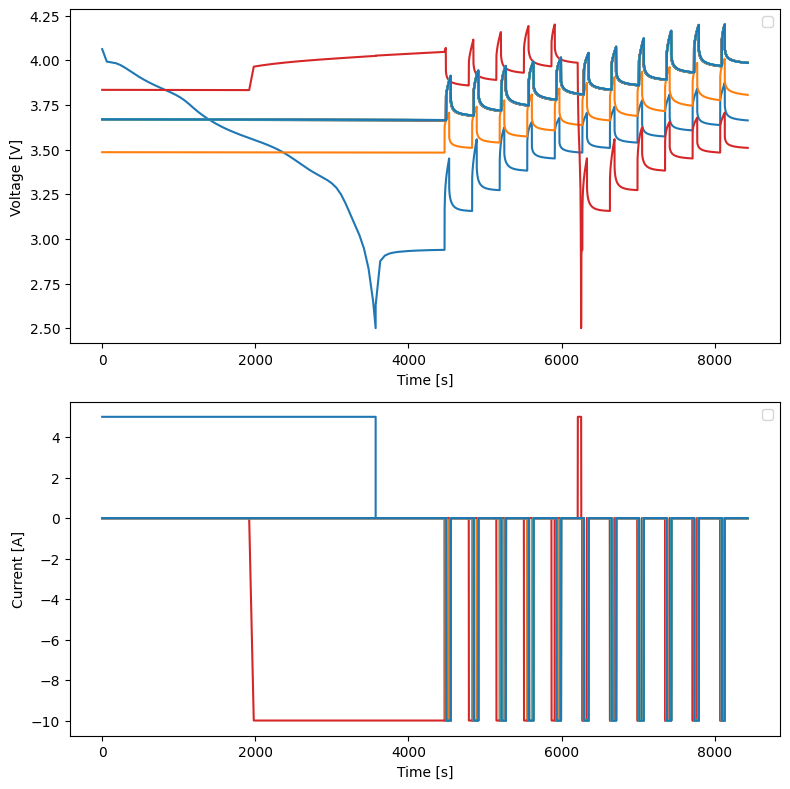

In [42]:
plot_given_range(solution, 0, num_entries)


In [58]:
solution[-1].t[3800:4000]

array([], dtype=float64)